#### Importing required packages

In [50]:
# Core
import os
import glob
import re
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy.stats import zscore
import scipy.stats as stats


# Time series
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor


# DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Attention, Input
from tensorflow.keras.models import Model

# Utils
import warnings
warnings.filterwarnings("ignore")


In [51]:
input_dir = "../data/"
model_dir = "../models/"
results_dir = "../results/"
reports_dir = "../reports"


In [52]:
# List to store dataframes
all_coins = []
# Iterate through all csv files in the directory
files = glob.glob(os.path.join(input_dir, "coin_*.csv"))
for filepath in files:
    try:
        # Read the file
        df_temp = pd.read_csv(filepath)
        # Extract coin name from filename if not in columns, or strictly use filename
        coin_name = os.path.basename(filepath).split('_')[1].split('.')[0]
        # Ensure we have a column for the coin name to distinguish after merging
        df_temp['Coin_Name'] = coin_name
        all_coins.append(df_temp)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")


In [53]:
def save_plot_from_title(fig=None, dpi=300):
    """
    Saves the current matplotlib figure using its title as filename.
    """
    if fig is None:
        fig = plt.gcf()
    title = plt.gca().get_title()
    if not title:
        raise ValueError("Plot must have a title to save automatically.")
    
    # Clean title for filename
    filename = re.sub(r'[^a-zA-Z0-9_-]', '_', title)
    filepath = os.path.join(reports_dir, f"{filename}.png")
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
    print(f"Saved plot: {filepath}")


In [54]:
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)


In [55]:
def create_lag_features(data: pd.DataFrame, target_col: str, max_lag: int = 30) -> pd.DataFrame:
    """
    Create lag features for a time-series target column.
    Parameters:
     data : pd.DataFrame
        Time-indexed dataframe
     target_col : str
        Target column name (e.g., 'Close')
     max_lag : int
        Number of lag features to create
    Returns:
    pd.DataFrame
        DataFrame with lag features
    """
    df_lag = data.copy()
    for lag in range(1, max_lag + 1):
        df_lag[f'{target_col}_lag_{lag}'] = df_lag[target_col].shift(lag)
    df_lag.dropna(inplace=True)
    return df_lag


In [56]:
## For ML model evaluation
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    direction_accuracy = np.mean(np.sign(y_true.diff().dropna().values) == np.sign(np.diff(y_pred)))
    return rmse, mae, mape, direction_accuracy
## For deep learning evaluation
def evaluate_forecast(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    eps = 1e-8
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100
    direction_accuracy = np.mean(np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1]))
    return rmse, mae, mape, direction_accuracy

def walk_forward_validation(model, X, y, train_size):
    preds, actuals = [], []
    for i in range(train_size, len(X)):
        X_train = X[:i]
        y_train = y[:i]
        X_test = X[i:i+1]
        model.fit(X_train, y_train)
        pred = model.predict(X_test)[0]
        preds.append(pred)
        actuals.append(y[i])
    return np.array(actuals), np.array(preds)


In [57]:
def multi_step_forecast_ml(model, last_features, steps, lag_indices):
    """
    model        : trained ML model
    last_features: 1D numpy array (last known row of features)
    steps        : forecast horizon (7 / 15 / 30)
    lag_indices  : indices of lag features in feature vector
                   (e.g., positions of Close_lag_1 ... Close_lag_n)
    """
    forecasts = []
    current_features = last_features.copy()

    for _ in range(steps):
        # Predict next step
        pred = model.predict(current_features.reshape(1, -1))[0]
        forecasts.append(pred)

        # Shift lag features
        for i in reversed(range(1, len(lag_indices))):
            current_features[lag_indices[i]] = current_features[lag_indices[i - 1]]

        # Insert new prediction as most recent lag
        current_features[lag_indices[0]] = pred

    return np.array(forecasts)


In [58]:
def multi_step_forecast_xgb(model, last_row, steps):
    """
    last_row: last known feature row (1D numpy array)
    steps: forecast horizon
    """
    preds = []
    current_input = last_row.copy()
    for _ in range(steps):
        pred = model.predict(current_input.reshape(1, -1))[0]
        preds.append(pred)
        # shift lag features
        current_input[1:] = current_input[:-1]
        current_input[0] = pred
    return np.array(preds)


def multi_step_directional_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()

    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))



In [59]:
def make_forecast_dates(y_test, steps):
    last_date = y_test.index[-1]
    return pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq='D')


In [60]:
def plot_multistep_forecast(y_test, forecast, steps, dir_acc, title_suffix=""):
    forecast_dates = make_forecast_dates(y_test, steps)
    plt.figure(figsize=(12,5))
    plt.plot(y_test.index[-steps:], y_test.values[-steps:], label="Actual", marker="o")
    plt.plot(forecast_dates, forecast, label="Forecast", marker="x")
    plt.axvline(y_test.index[-1], linestyle="--", color="gray", label="Forecast Start")
    plt.title(f"{steps}-Day Forecast {title_suffix}\n"f"Directional Accuracy = {dir_acc:.2%}")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(True)
    save_plot_from_title()
    plt.show()


#### Load the Datasets
Here, I used BitCoin dataset

In [61]:
# Concatenate all into one master dataframe
# df = pd.concat(all_coins, axis=0, ignore_index=True)
df = pd.read_csv("../data/coin_Bitcoin.csv")


In [62]:
print(f"Total Rows: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")
# print(f"Unique Coins: {df['Coin_Name'].nunique()}")


Total Rows: 2991
Total Columns: 10


## Data Understanding & EDA Requirements

In [63]:
df.dtypes


SNo            int64
Name          object
Symbol        object
Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object

In [64]:
# Convert Date to datetime object
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes


SNo                   int64
Name                 object
Symbol               object
Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Marketcap           float64
dtype: object

In [65]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SNo        2991 non-null   int64         
 1   Name       2991 non-null   object        
 2   Symbol     2991 non-null   object        
 3   Date       2991 non-null   datetime64[ns]
 4   High       2991 non-null   float64       
 5   Low        2991 non-null   float64       
 6   Open       2991 non-null   float64       
 7   Close      2991 non-null   float64       
 8   Volume     2991 non-null   float64       
 9   Marketcap  2991 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 233.8+ KB


### Plot for Close Price history

Saved plot: ../reports\Bitcoin_Close_Price.png


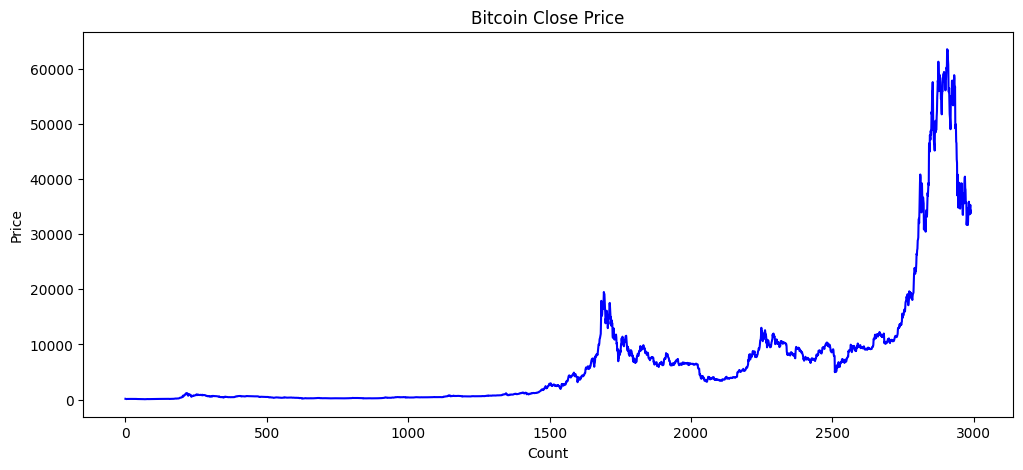

In [66]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'], color='blue')
plt.title("Bitcoin Close Price")
plt.xlabel("Count")
plt.ylabel("Price")
save_plot_from_title()
plt.show()


#### Identifying Trend

In [67]:
df['MA_7']  = df['Close'].rolling(window=7).mean()
df['MA_15'] = df['Close'].rolling(window=15).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df.head(40)


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,MA_7,MA_15,MA_30
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,NaN,NaN,NaN
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,NaN,NaN,NaN
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,NaN,NaN,NaN
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,NaN,NaN,NaN
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,NaN,NaN,NaN
5,6,Bitcoin,BTC,2013-05-04 23:59:59,115.000000,92.500000,98.099998,112.500000,0.0,1.250317e+09,NaN,NaN,NaN
6,7,Bitcoin,BTC,2013-05-05 23:59:59,118.800003,107.142998,112.900002,115.910004,0.0,1.288693e+09,118.842856,NaN,NaN
7,8,Bitcoin,BTC,2013-05-06 23:59:59,124.663002,106.639999,115.980003,112.300003,0.0,1.249023e+09,114.237143,NaN,NaN
8,9,Bitcoin,BTC,2013-05-07 23:59:59,113.444000,97.699997,112.250000,111.500000,0.0,1.240594e+09,110.308572,NaN,NaN
9,10,Bitcoin,BTC,2013-05-08 23:59:59,115.779999,109.599998,109.599998,113.566002,0.0,1.264049e+09,109.819430,NaN,NaN


Saved plot: ../reports\Trend_Identification_using_Moving_Averages.png


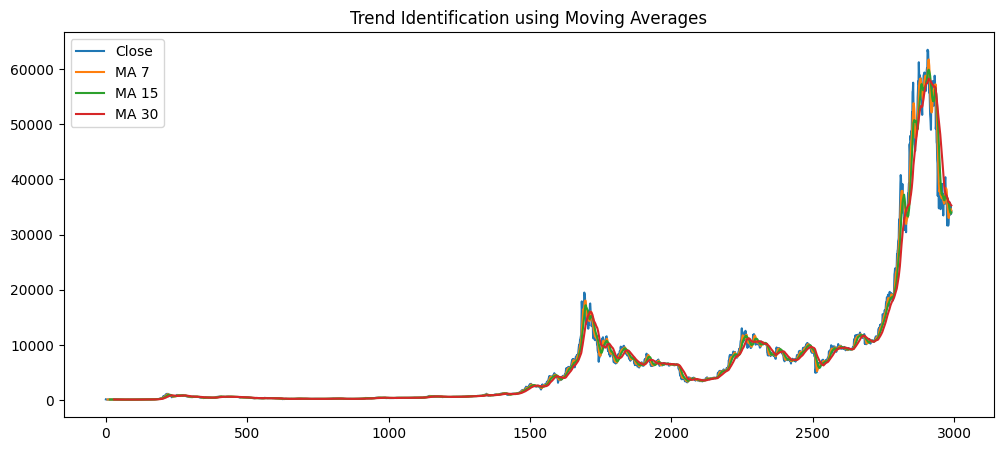

In [68]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_7'], label='MA 7')
plt.plot(df['MA_15'], label='MA 15')
plt.plot(df['MA_30'], label='MA 30')
plt.legend()
plt.title("Trend Identification using Moving Averages")
save_plot_from_title()
plt.show()


#### Seasonality identification

In [69]:
stl = STL(df['Close'], period=30)  # Montly seasonality
result = stl.fit()


In [70]:
df['Trend'] = result.trend
df['Seasonal'] = result.seasonal
df['Residual'] = result.resid


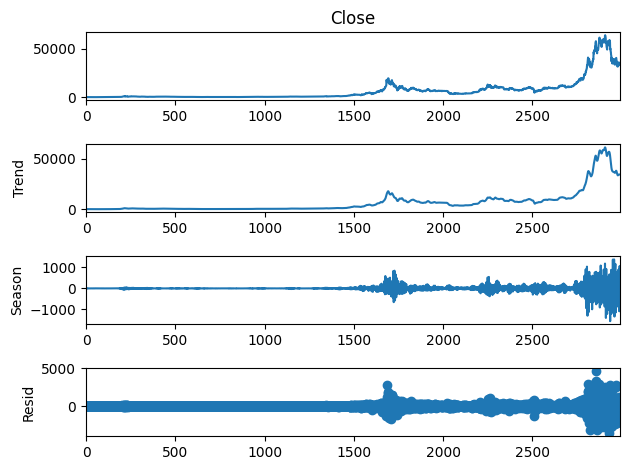

In [229]:
fig = result.plot()
fig.savefig(reports_dir + "/Monthly_STL_Decomposition_Bitcoin_Close_Price.png", dpi=300, bbox_inches="tight")
plt.show()


In [230]:
stl = STL(df['Close'], period=7)
result = stl.fit()


In [231]:
df['Trend'] = result.trend
df['Seasonal'] = result.seasonal
df['Residual'] = result.resid


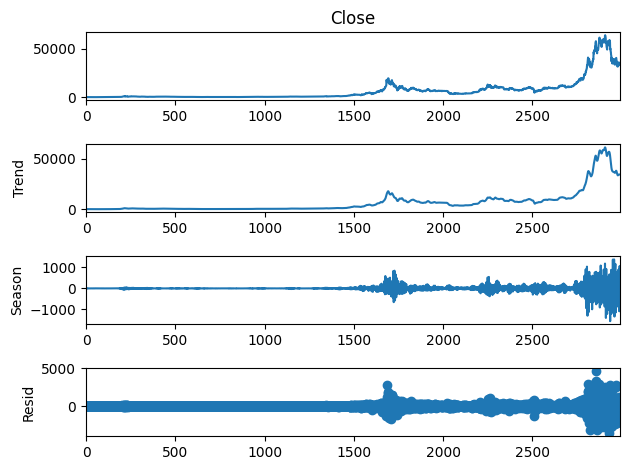

In [232]:
fig = result.plot()
fig.savefig(reports_dir + "/Weekly_STL_Decomposition_Bitcoin_Close_Price.png", dpi=300, bbox_inches="tight")
plt.show()


#### Volatility Identification

In [75]:
## Log return
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))


In [76]:
## Roling volatility
df['volatility_7']  = df['log_return'].rolling(7).std()
df['volatility_15'] = df['log_return'].rolling(15).std()
df['volatility_30'] = df['log_return'].rolling(30).std()


Saved plot: ../reports\Rolling_Volatility__Crypto_.png


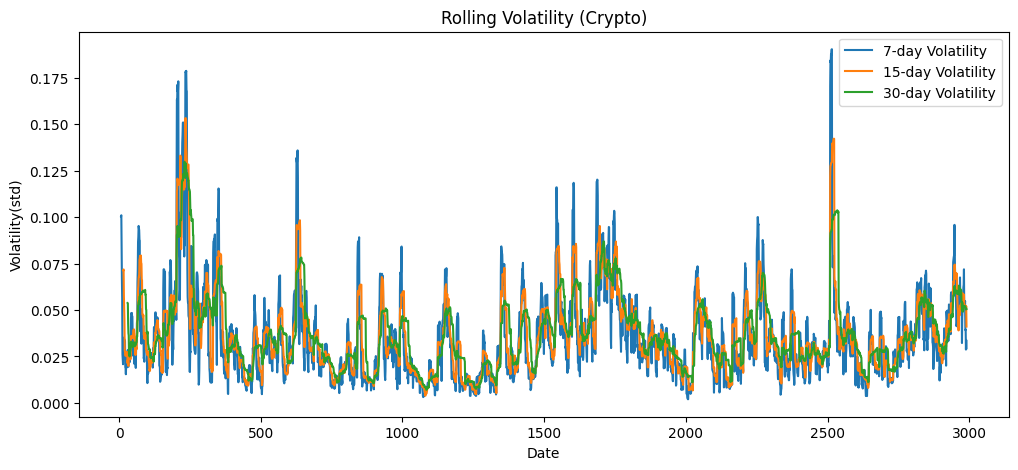

In [77]:
plt.figure(figsize=(12,5))
plt.plot(df['volatility_7'], label='7-day Volatility')
plt.plot(df['volatility_15'], label='15-day Volatility')
plt.plot(df['volatility_30'], label='30-day Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility(std)')
plt.legend()
plt.title("Rolling Volatility (Crypto)")
save_plot_from_title()
plt.show()


In [78]:
vol_threshold = df['volatility_30'].quantile(0.75)
df['volatility_regime_30'] = np.where(df['volatility_30'] > vol_threshold,'High Volatility','Low Volatility')


Saved plot: ../reports\Volatility_7-day_Rolling_Std_.png


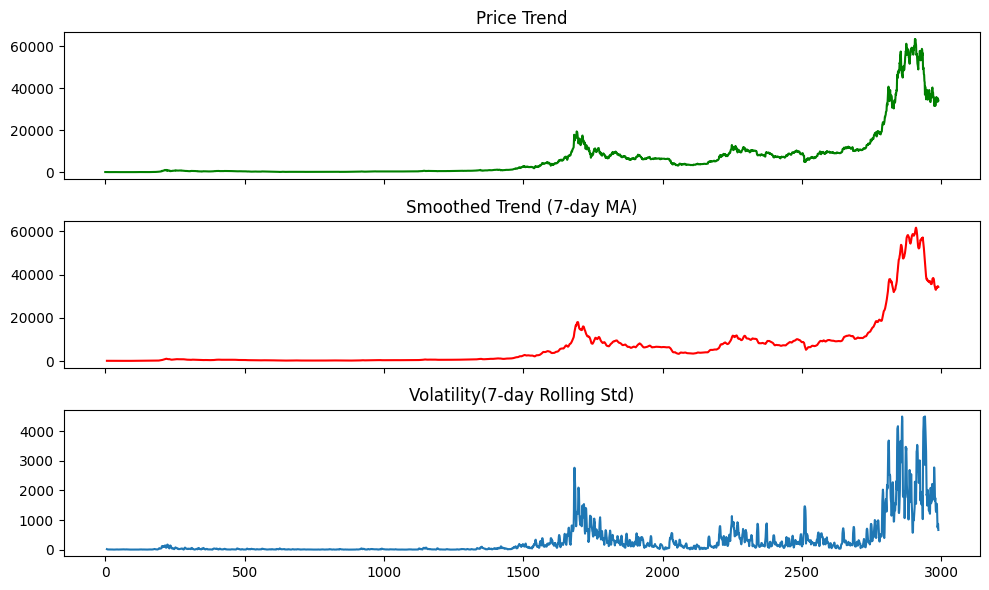

In [79]:
fig, axes = plt.subplots(3, 1, figsize=(10,6), sharex=True)
axes[0].plot(df['Close'], color = 'green')
axes[0].set_title('Price Trend')
axes[1].plot(df['Close'].rolling(7).mean(), color = 'red')
axes[1].set_title('Smoothed Trend (7-day MA)')
axes[2].plot(df['Close'].rolling(7).std())
axes[2].set_title('Volatility(7-day Rolling Std)')
plt.tight_layout()
save_plot_from_title()
plt.show()


Saved plot: ../reports\Volatility__30-day_Rolling_Std_.png


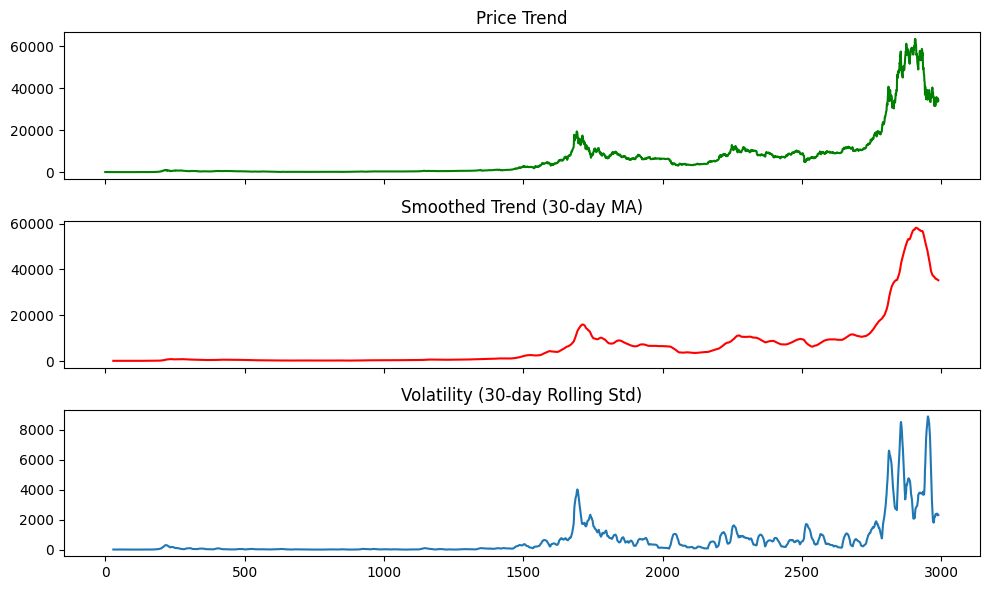

In [80]:
fig, axes = plt.subplots(3, 1, figsize=(10,6), sharex=True)
axes[0].plot(df['Close'], color = 'green')
axes[0].set_title('Price Trend')
axes[1].plot(df['Close'].rolling(30).mean(), color = 'red')
axes[1].set_title('Smoothed Trend (30-day MA)')
axes[2].plot(df['Close'].rolling(30).std())
axes[2].set_title('Volatility (30-day Rolling Std)')
plt.tight_layout()
save_plot_from_title()
plt.show()


Saved plot: ../reports\Volatility_Regimes_Count.png


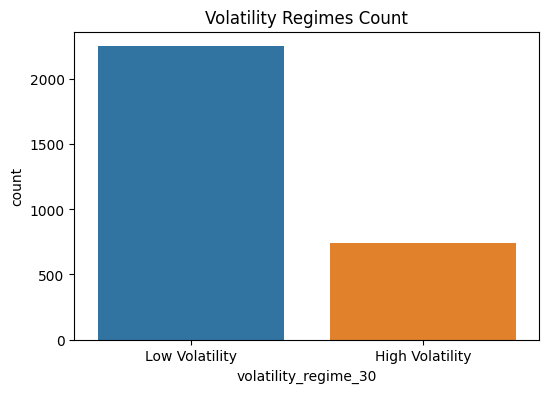

In [81]:
plt.figure(figsize=(6,4))
sns.countplot(x = "volatility_regime_30", data = df)
plt.title("Volatility Regimes Count")
save_plot_from_title()
plt.show()


Saved plot: ../reports\Log_Return_Bitcoin_Price_Trend.png


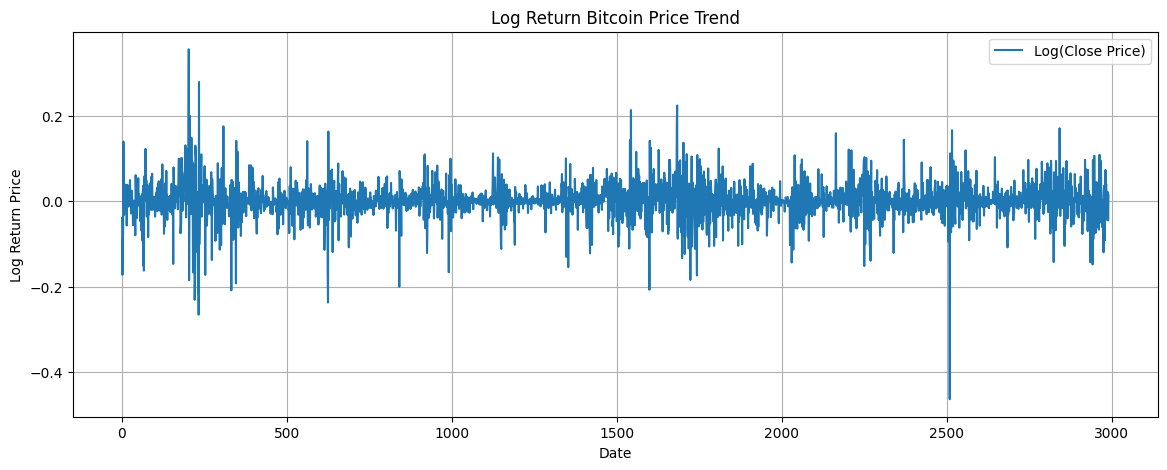

In [82]:
plt.figure(figsize=(14,5))
plt.plot(df['log_return'], label='Log(Close Price)')
plt.title('Log Return Bitcoin Price Trend')
plt.xlabel('Date')
plt.ylabel('Log Return Price')
plt.legend()
plt.grid(True)
save_plot_from_title()
plt.show()


B. ACF Plots (Seasonality Checks)

Saved plot: ../reports\ACF_Plot___Seasonality_Detection.png


<Figure size 1000x300 with 0 Axes>

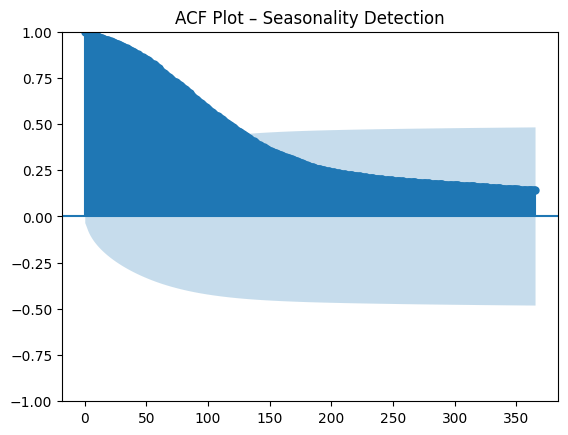

In [83]:
plt.figure(figsize=(10,3))
plot_acf(df['Close'], lags=365, )
plt.title('ACF Plot – Seasonality Detection')
save_plot_from_title()
plt.show()


##### Perform ADF Test for Stationarity

In [84]:
adf_test = adfuller(df['Close'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -0.7973098451195634
p-value: 0.8199110033239144
Critical Values:
   1%: -3.4325603944919445
   5%: -2.8625166073924957
   10%: -2.567289874591689


##### Plot ACF & PACF for Lag Relationships

Saved plot: ../reports\PACF_Plot.png


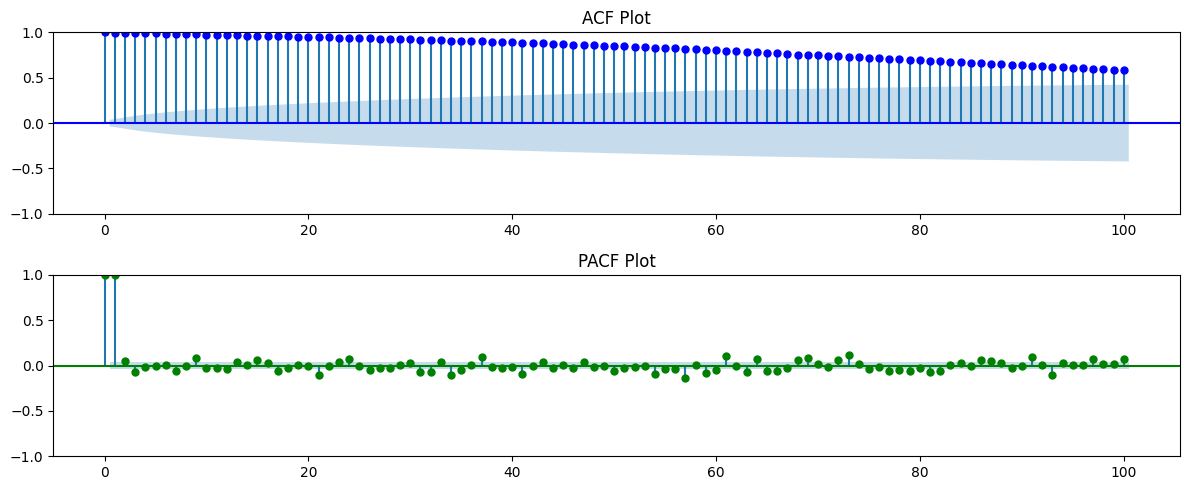

In [85]:
fig, axes = plt.subplots(2, 1, figsize=(12,5))
plot_acf(df['Close'], lags=100, ax=axes[0], color = 'blue')
plot_pacf(df['Close'], lags=100, ax=axes[1], color = 'green')
axes[0].set_title("ACF Plot")
axes[1].set_title("PACF Plot")
plt.tight_layout()
save_plot_from_title()
plt.show()


##### Plot Moving Averages

Saved plot: ../reports\Moving_Averages_of_Bitcoin_Price.png


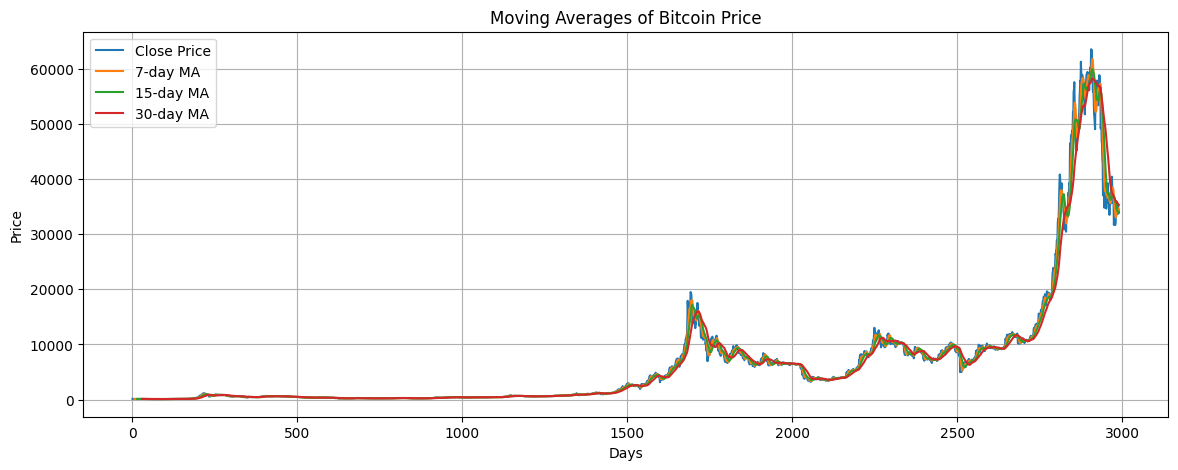

In [86]:
plt.figure(figsize=(14,5))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA_7'], label='7-day MA')
plt.plot(df['MA_15'], label='15-day MA')
plt.plot(df["MA_30"], label='30-day MA')
plt.title("Moving Averages of Bitcoin Price")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
save_plot_from_title()
plt.show()


##### Investigate Correlation Between Volume and Price

Correlation values between features

Saved plot: ../reports\Correlation_Heatmap_between_Close_Price_and_Volume.png


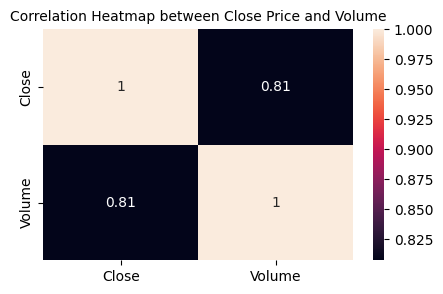

In [87]:
corr = df[['Close', 'Volume']].corr()

plt.figure(figsize=(5,3))
sns.heatmap(corr, annot = True, )
plt.title("Correlation Heatmap between Close Price and Volume", fontsize=10)
save_plot_from_title()
plt.show()


Scatter Plot

Saved plot: ../reports\Scatter_plot_between_Volume_vs_Close_Price.png


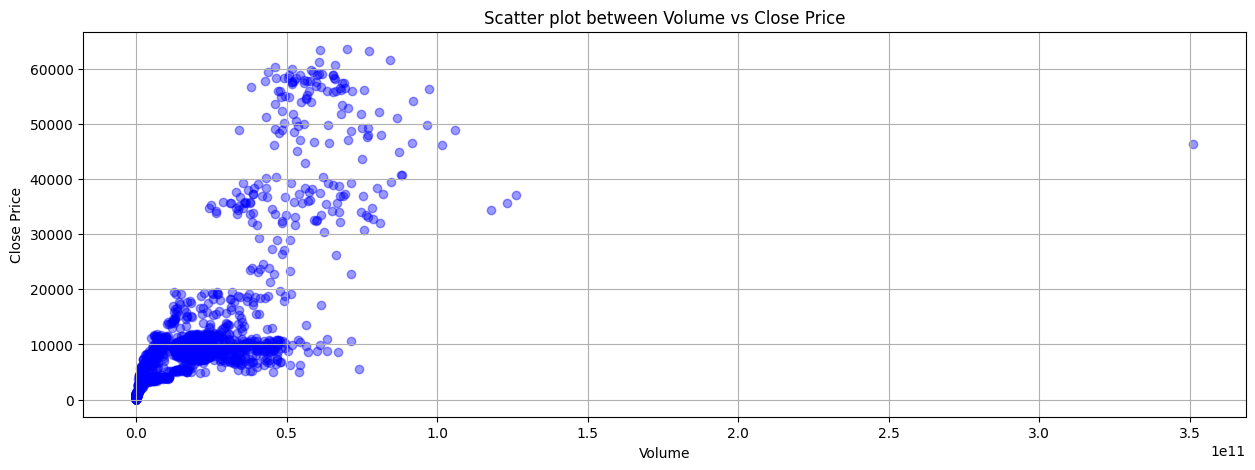

In [88]:
plt.figure(figsize=(15, 5))
plt.scatter(df['Volume'], df['Close'], alpha=0.4, color = 'blue')
plt.title("Scatter plot between Volume vs Close Price")
plt.xlabel("Volume")
plt.ylabel("Close Price")
plt.grid(True)
save_plot_from_title()
plt.show()


##### Detect Anomalies / Outliers

##### Price Distribution

Saved plot: ../reports\Price_Distribution__Outlier_Detection_.png


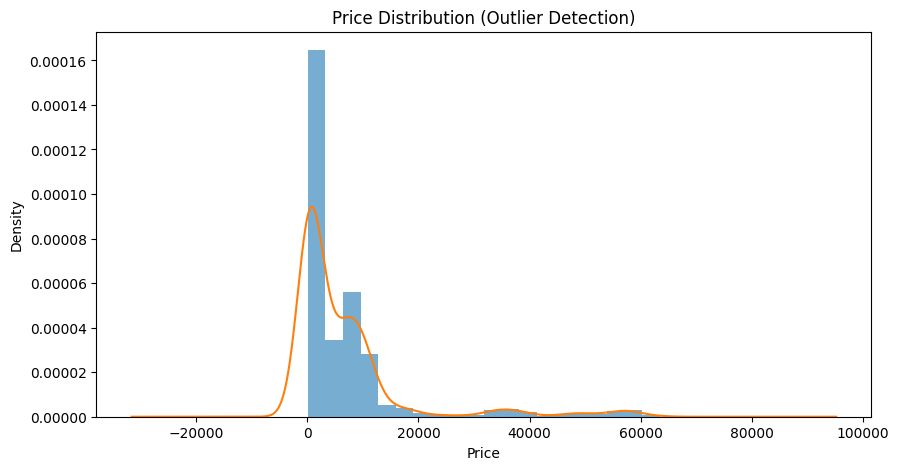

In [89]:
plt.figure(figsize=(10,5))
plt.hist(df['Close'], bins=20, density=True, alpha=0.6)
df['Close'].plot(kind='kde')
plt.title("Price Distribution (Outlier Detection)")
plt.xlabel("Price")
save_plot_from_title()
plt.show()


##### Log Return Distribution

Saved plot: ../reports\Log_Return_Distribution__Outlier_Detection_.png


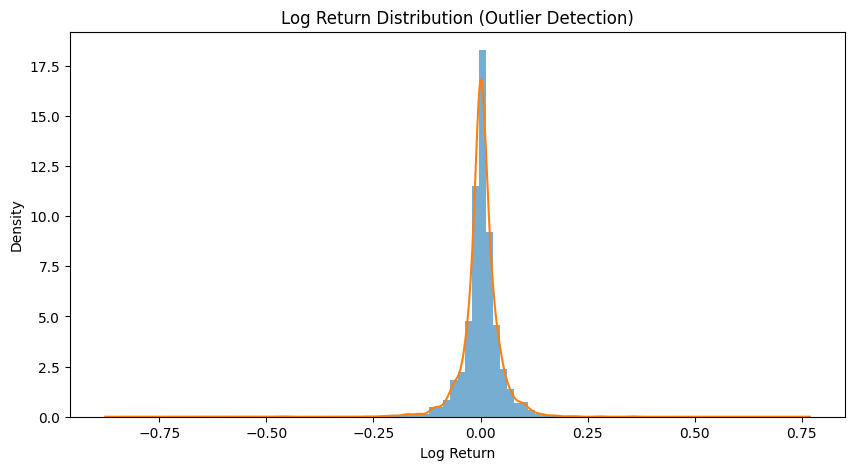

In [90]:
plt.figure(figsize=(10,5))
plt.hist(df['log_return'].dropna(), bins=50, density=True, alpha=0.6)
df['log_return'].dropna().plot(kind='kde')
plt.title("Log Return Distribution (Outlier Detection)")
plt.xlabel("Log Return")
save_plot_from_title()
plt.show()


##### Box Plot

Saved plot: ../reports\Box_Plot_Outlier_Detection__Log_Returns_.png


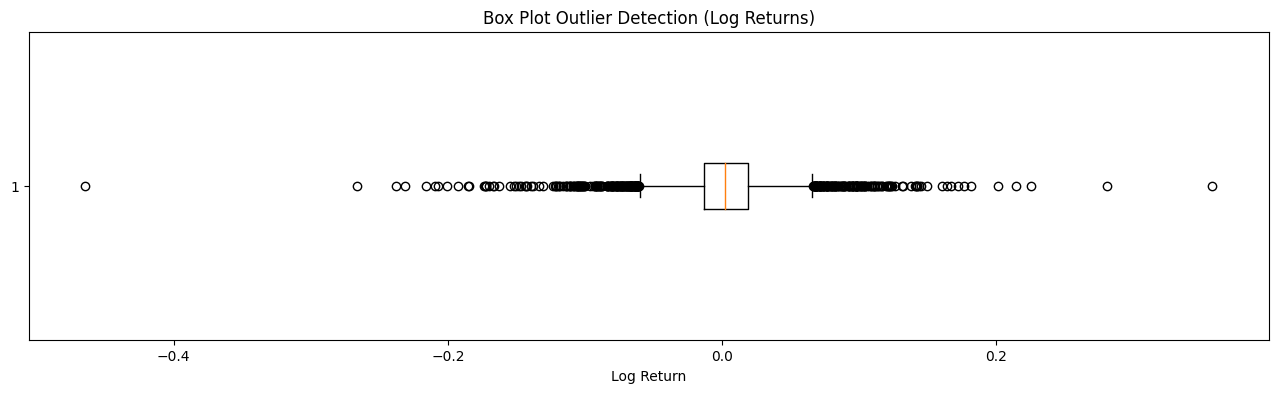

In [91]:
plt.figure(figsize=(16,4))
plt.boxplot(df['log_return'].dropna(), vert=False)
plt.title("Box Plot Outlier Detection (Log Returns)")
plt.xlabel("Log Return")
save_plot_from_title()
plt.show()


##### IQR-based Outlier Thresholds (Visual + Numeric)

In [92]:
Q1 = df['log_return'].quantile(0.25)
Q3 = df['log_return'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['log_return'] < lower_bound) | (df['log_return'] > upper_bound)]


Saved plot: ../reports\IQR-Based_Outlier_Thresholds.png


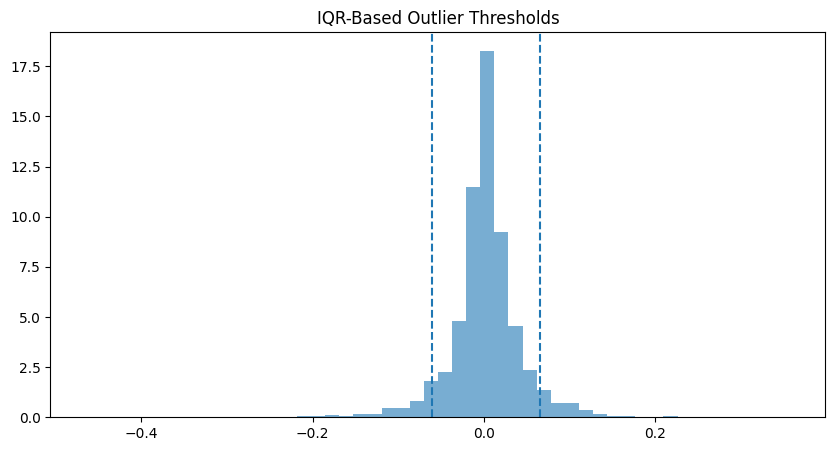

In [93]:
## Visualize bounds on distribution
plt.figure(figsize=(10,5))
plt.hist(df['log_return'].dropna(), bins=50, density=True, alpha=0.6)
plt.axvline(lower_bound, linestyle='--')
plt.axvline(upper_bound, linestyle='--')
plt.title("IQR-Based Outlier Thresholds")
save_plot_from_title()
plt.show()


##### Z-Score Distribution Plot

In [94]:
len(df['log_return'])


2991

In [95]:
df.isnull().sum()


SNo                      0
Name                     0
Symbol                   0
Date                     0
High                     0
Low                      0
Open                     0
Close                    0
Volume                   0
Marketcap                0
MA_7                     6
MA_15                   14
MA_30                   29
Trend                    0
Seasonal                 0
Residual                 0
log_return               1
volatility_7             7
volatility_15           15
volatility_30           30
volatility_regime_30     0
dtype: int64

In [96]:
df.head()


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,MA_15,MA_30,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,...,NaN,NaN,124.513648,13.510565,6.515781,NaN,NaN,NaN,NaN,Low Volatility
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,...,NaN,NaN,122.352521,9.877990,6.769489,-0.039082,NaN,NaN,NaN,Low Volatility
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,...,NaN,NaN,120.357377,-2.213524,-1.153856,-0.172385,NaN,NaN,NaN,Low Volatility
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,...,NaN,NaN,118.507575,-8.172636,-5.124941,-0.106130,NaN,NaN,NaN,Low Volatility
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,...,NaN,NaN,116.770600,-9.894992,-9.125608,-0.073545,NaN,NaN,NaN,Low Volatility


Saved plot: ../reports\Log_Return_Scatter_Plot.png


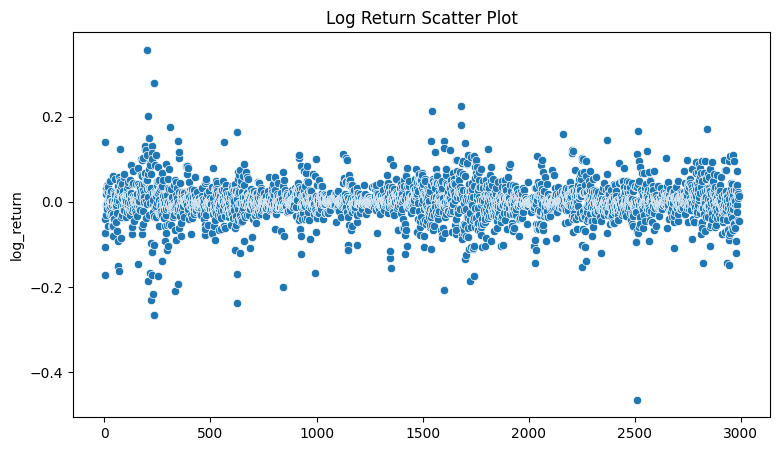

In [97]:
plt.figure(figsize = (9,5))
sns.scatterplot(df['log_return'])
plt.title("Log Return Scatter Plot")
save_plot_from_title()
plt.show()


In [98]:
df.dtypes


SNo                              int64
Name                            object
Symbol                          object
Date                    datetime64[ns]
High                           float64
Low                            float64
Open                           float64
Close                          float64
Volume                         float64
Marketcap                      float64
MA_7                           float64
MA_15                          float64
MA_30                          float64
Trend                          float64
Seasonal                       float64
Residual                       float64
log_return                     float64
volatility_7                   float64
volatility_15                  float64
volatility_30                  float64
volatility_regime_30            object
dtype: object

In [99]:
df1 = df.fillna(df.mean())


In [100]:
df1['z_score'] = zscore(df1['log_return'])
df1


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,MA_30,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,...,6606.573392,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,...,6606.573392,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,...,6606.573392,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,...,6606.573392,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,...,6606.573392,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,...,35618.790261,34332.563133,-1095.522467,660.007923,0.009632,0.039215,0.052242,0.051774,High Volatility,1.825632e-01
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,...,35467.449674,34335.445545,-130.190373,463.293229,0.022505,0.039432,0.050547,0.051287,High Volatility,4.837258e-01
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,...,35413.895489,34327.893632,1070.089444,-110.203309,0.017704,0.028708,0.050795,0.050286,High Volatility,3.714033e-01
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11,...,35353.696946,34308.663792,-446.144558,-116.516778,-0.044675,0.033890,0.052035,0.050490,High Volatility,-1.087951e+00


In [101]:
# df2 = df.fillna(df.mean())
# df2['z_score'] = zscore(df2['log_return'])
# df2
# plt.figure(figsize=(10,5))
# plt.hist(np.abs(df2['z_score']), bins=50, density=True)
# plt.axvline(3, linestyle='--')
# plt.axvline(-3, linestyle='--')
# plt.title("Z-Score Distribution for Outlier Detection")
# plt.xlabel("Z-Score")
# plt.show()


Saved plot: ../reports\Z-Score_Distribution_for_Outlier_Detection.png


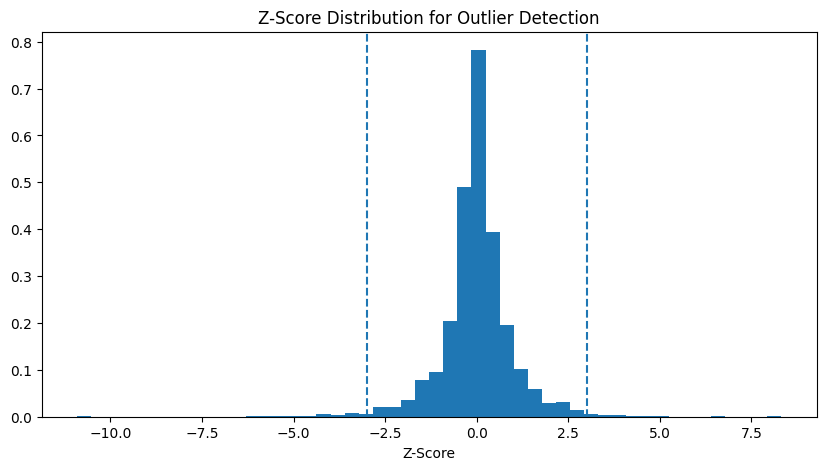

In [102]:
plt.figure(figsize=(10,5))
plt.hist(df1['z_score'], bins=50, density=True)
plt.axvline(3, linestyle='--')
plt.axvline(-3, linestyle='--')
plt.title("Z-Score Distribution for Outlier Detection")
plt.xlabel("Z-Score")
save_plot_from_title()
plt.show()


Saved plot: ../reports\QQ_Plot_Outlier_Detection.png


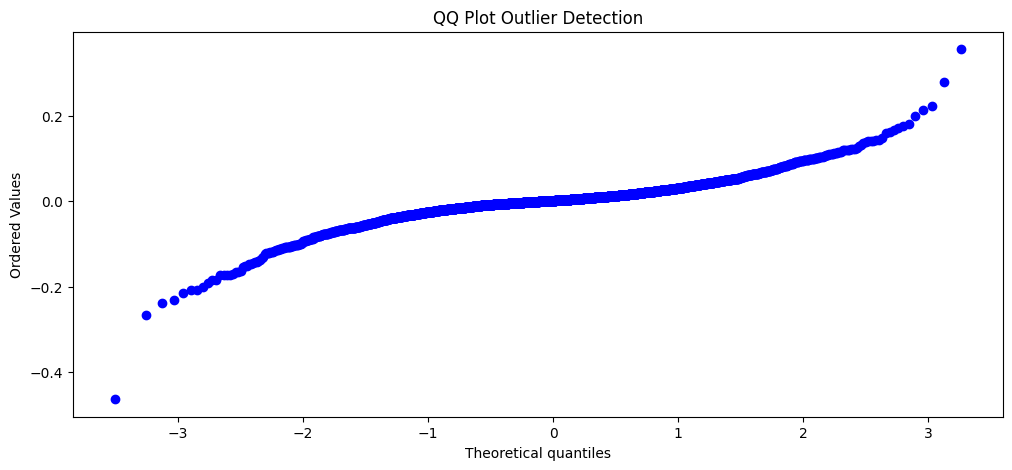

In [103]:
plt.figure(figsize=(12,5))
stats.probplot(df['log_return'], dist="norm", plot=plt)
plt.title("QQ Plot Outlier Detection")
save_plot_from_title()
plt.show()


In [104]:
df1['log_return_capped'] = df1['log_return'].clip(lower_bound, upper_bound)
df1[['log_return','log_return_capped']]


,log_return,log_return_capped
0,0.001829,0.001829
1,-0.039082,-0.039082
2,-0.172385,-0.060476
3,-0.106130,-0.060476
4,-0.073545,-0.060476
...,...,...
2986,0.009632,0.009632
2987,0.022505,0.022505
2988,0.017704,0.017704
2989,-0.044675,-0.044675


Saved plot: ../reports\Log_Return_Distribution__Outlier_Detection_.png


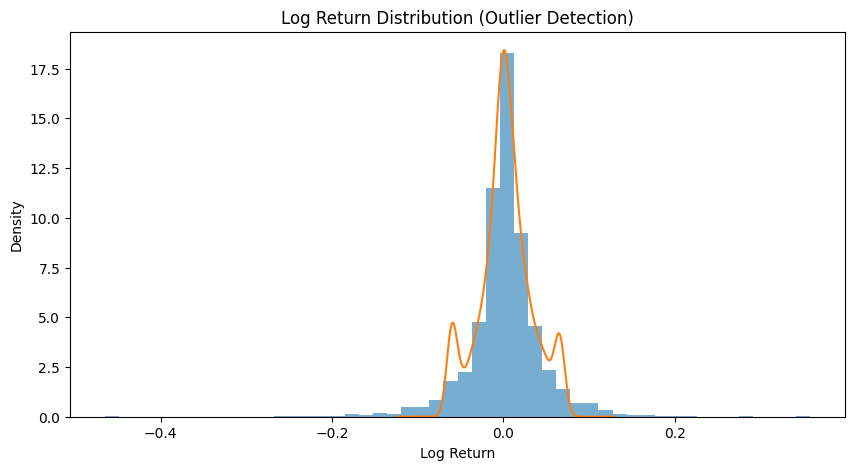

In [105]:
plt.figure(figsize=(10,5))
plt.hist(df1['log_return'], bins=50, density=True, alpha=0.6)
df1['log_return_capped'].dropna().plot(kind='kde')
plt.title("Log Return Distribution (Outlier Detection)")
plt.xlabel("Log Return")
save_plot_from_title()
plt.show()


In [106]:
df1.columns


Index(['SNo', 'Name', 'Symbol', 'Date', 'High', 'Low', 'Open', 'Close',
       'Volume', 'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'Trend', 'Seasonal',
       'Residual', 'log_return', 'volatility_7', 'volatility_15',
       'volatility_30', 'volatility_regime_30', 'z_score',
       'log_return_capped'],
      dtype='object')

Saved plot: ../reports\Z-Score_Time_Series_after_Outlier_Removal.png


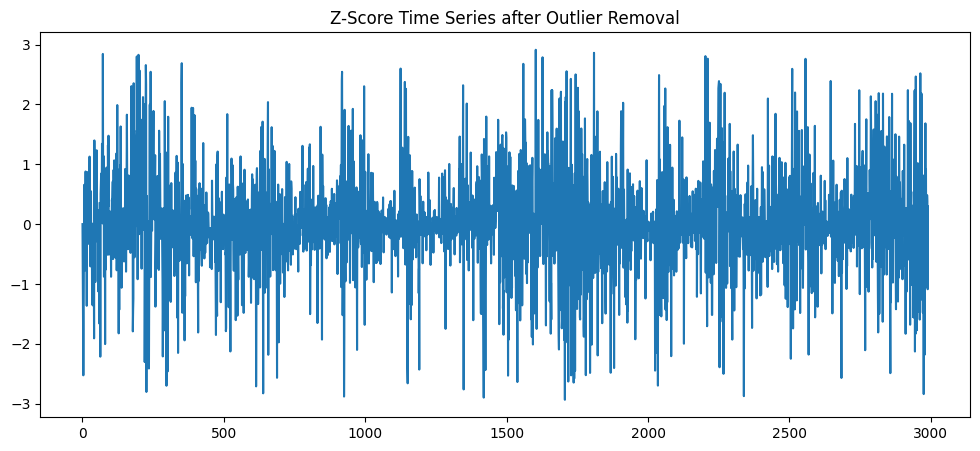

In [107]:
outlier_removal_df = df1[np.abs(df1['z_score']) <= 3]
plt.figure(figsize=(12,5))
plt.plot(outlier_removal_df.z_score)
plt.title("Z-Score Time Series after Outlier Removal")
save_plot_from_title()
plt.show()


B. Visualizing Outliers

Saved plot: ../reports\Outlier_Detection.png


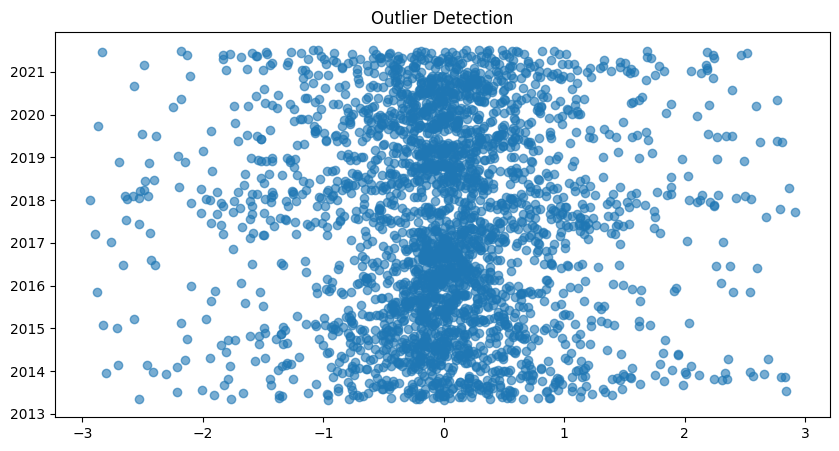

In [108]:
plt.figure(figsize=(10,5))
plt.scatter(outlier_removal_df.z_score, outlier_removal_df.Date, alpha=0.6)
plt.title("Outlier Detection")
save_plot_from_title()
plt.show()


Saved plot: ../reports\Box_Plot_Outlier_Detection__Close_Price_.png


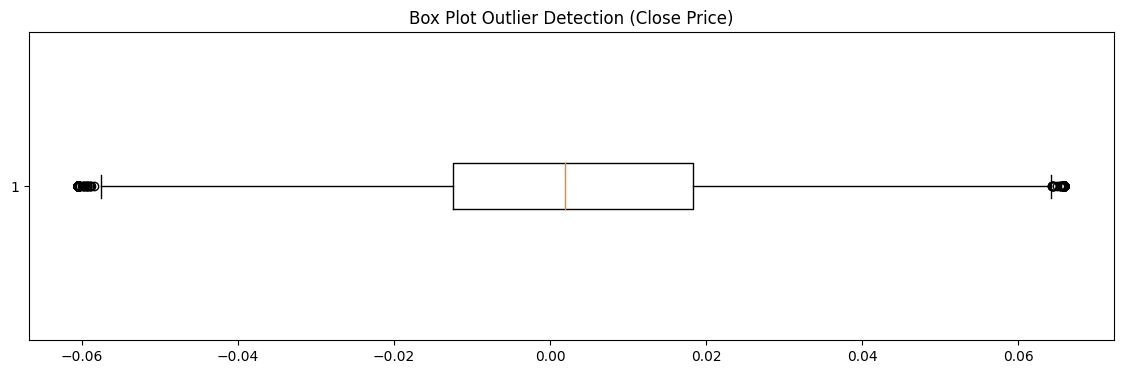

In [109]:
plt.figure(figsize=(14,4))
plt.boxplot(outlier_removal_df.log_return_capped, vert=False)
plt.title("Box Plot Outlier Detection (Close Price)")
save_plot_from_title()
plt.show()      


## Data Preprocessing

In [110]:
data = df1.sort_values('Date')
data.set_index('Date', inplace=True)


In [111]:
# Ensure datetime index
data.index = pd.to_datetime(data.index)
data.head()


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,MA_7,...,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,6690.163677,...,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,6690.163677,...,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,6690.163677,...,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00,-0.060476
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,6690.163677,...,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,6690.163677,...,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476


In [112]:
# Check missing dates
missing_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D').difference(data.index)
print(f"Missing timestamps: {len(missing_dates)}")


Missing timestamps: 0


In [113]:
data.columns


Index(['SNo', 'Name', 'Symbol', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'Trend', 'Seasonal', 'Residual',
       'log_return', 'volatility_7', 'volatility_15', 'volatility_30',
       'volatility_regime_30', 'z_score', 'log_return_capped'],
      dtype='object')

#### Scale data using training-only fit (no leakage)
##### Chronological Split (Used Before Scaling)

In [114]:
final_data = data.copy()


In [115]:
final_data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'log_return', 'volatility_7', 'volatility_15', 'volatility_30', 'volatility_regime_30', 'z_score', 'log_return_capped']]


,High,Low,Open,Close,Volume,Marketcap,MA_7,MA_15,MA_30,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
Date,,,,,,,,,,,,,,,,
2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,6690.163677,6661.912140,6606.573392,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,6690.163677,6661.912140,6606.573392,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,6690.163677,6661.912140,6606.573392,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00,-0.060476
2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,6690.163677,6661.912140,6606.573392,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,6690.163677,6661.912140,6606.573392,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,34235.434114,34063.669852,35618.790261,0.009632,0.039215,0.052242,0.051774,High Volatility,1.825632e-01,0.009632
2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,34590.044219,33989.090093,35467.449674,0.022505,0.039432,0.050547,0.051287,High Volatility,4.837258e-01,0.022505
2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,34681.206387,33967.217460,35413.895489,0.017704,0.028708,0.050795,0.050286,High Volatility,3.714033e-01,0.017704


In [116]:
encoded_data = data.copy()


In [117]:
encode = {"Low Volatility":0, "High Volatility":1}
encoded_data["volatility_regime_30"] = encoded_data.volatility_regime_30.map(encode)


In [118]:
added_lag_features_df = create_lag_features(encoded_data, target_col='Close', max_lag=30)
added_lag_features_df.columns


Index(['SNo', 'Name', 'Symbol', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'Trend', 'Seasonal', 'Residual',
       'log_return', 'volatility_7', 'volatility_15', 'volatility_30',
       'volatility_regime_30', 'z_score', 'log_return_capped', 'Close_lag_1',
       'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5',
       'Close_lag_6', 'Close_lag_7', 'Close_lag_8', 'Close_lag_9',
       'Close_lag_10', 'Close_lag_11', 'Close_lag_12', 'Close_lag_13',
       'Close_lag_14', 'Close_lag_15', 'Close_lag_16', 'Close_lag_17',
       'Close_lag_18', 'Close_lag_19', 'Close_lag_20', 'Close_lag_21',
       'Close_lag_22', 'Close_lag_23', 'Close_lag_24', 'Close_lag_25',
       'Close_lag_26', 'Close_lag_27', 'Close_lag_28', 'Close_lag_29',
       'Close_lag_30'],
      dtype='object')

In [119]:
added_lag_features_df['target'] = added_lag_features_df['log_return'].shift(-1)
added_lag_features_df.head()


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,MA_7,...,Close_lag_22,Close_lag_23,Close_lag_24,Close_lag_25,Close_lag_26,Close_lag_27,Close_lag_28,Close_lag_29,Close_lag_30,target
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-29 23:59:59,31,Bitcoin,BTC,132.589996,127.662003,129.000000,132.300003,0.0,1.483735e+09,130.914998,...,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,-0.026819
2013-05-30 23:59:59,32,Bitcoin,BTC,132.250000,127.000000,132.250000,128.798996,0.0,1.445054e+09,131.214855,...,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,0.001559
2013-05-31 23:59:59,33,Bitcoin,BTC,129.899994,126.400002,128.798996,129.000000,0.0,1.447870e+09,130.614855,...,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,0.002323
2013-06-01 23:59:59,34,Bitcoin,BTC,129.779999,127.198997,128.815002,129.300003,0.0,1.451916e+09,130.231999,...,117.199997,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,-0.055724
2013-06-02 23:59:59,35,Bitcoin,BTC,129.399994,115.050003,129.300003,122.292000,0.0,1.373837e+09,128.633714,...,115.242996,117.199997,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,-0.000573


In [120]:
INPUT_FEATURES = ['Volume', 'Marketcap', # Market information
                  'MA_7', 'MA_15', 'MA_30', # Trend indicators
                  'volatility_7', 'volatility_15', 'volatility_30', # Volatility indicators (CRITICAL for crypto)
                  'volatility_regime_30', # Regime & distribution info
                  'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5', 'Close_lag_6', 
                  'Close_lag_7', 'Close_lag_8', 'Close_lag_9', 'Close_lag_10', 'Close_lag_11', 'Close_lag_12', 
                  'Close_lag_13', 'Close_lag_14', 'Close_lag_15', 'Close_lag_16', 'Close_lag_17', 'Close_lag_18', 
                  'Close_lag_19', 'Close_lag_20', 'Close_lag_21', 'Close_lag_22', 'Close_lag_23', 'Close_lag_24', 
                  'Close_lag_25', 'Close_lag_26', 'Close_lag_27', 'Close_lag_28', 'Close_lag_29', 'Close_lag_30']
TARGET = 'target'


In [121]:
model_df = added_lag_features_df[INPUT_FEATURES + ['target']].dropna()


In [122]:
n = len(model_df)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)
X_train = model_df[INPUT_FEATURES].iloc[:train_end]
y_train = model_df[TARGET].iloc[:train_end]
X_val = model_df[INPUT_FEATURES].iloc[train_end:val_end]
y_val = model_df[TARGET].iloc[train_end:val_end]
X_test = model_df[INPUT_FEATURES].iloc[val_end:]
y_test = model_df[TARGET].iloc[val_end:]


In [123]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


(2072, 39) (2072,) (444, 39) (444,) (444, 39) (444,)


##### Scalling

In [124]:
X_scaler = MinMaxScaler()
X_scaler.fit(X_train)


MinMaxScaler()

In [125]:
joblib.dump(X_scaler, model_dir + 'X_scaler.pkl')


['../models/X_scaler.pkl']

In [126]:
# TRANSFORM all splits
X_train_scaled = X_scaler.transform(X_train)
X_val_scaled   = X_scaler.transform(X_val)
X_test_scaled  = X_scaler.transform(X_test)


In [127]:
y_scaler = MinMaxScaler()



In [128]:
joblib.dump(y_scaler, model_dir + 'y_scaler.pkl')


['../models/y_scaler.pkl']

In [129]:


# reshape because scaler expects 2D
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1))


In [130]:
print(X_train_scaled.min(), X_train_scaled.max())  # should be ~0 to 1
print(X_test_scaled.min(), X_test_scaled.max())    # may exceed [0,1] → OK
print(X_val_scaled.min(), X_val_scaled.max())


0.0 1.0000000000000002
0.0 14.721254446786158
0.0 3.1104855505241367


### Baseline model

Evaluation Method

#### Model_1 == ARIMA

In [131]:
# Fit ARIMA on training close price
arima_model = ARIMA(y_train, order=(1,0,1))
arima_fit = arima_model.fit()


In [132]:
arima_preds = arima_fit.forecast(steps=len(y_val))


In [133]:
arima_rmse, arima_mae, arima_mape, arima_dir = evaluate_model(y_val.reset_index(drop=True),pd.Series(arima_preds))
arima_rmse, arima_mae, arima_mape, arima_dir


(0.04258402136172869, 0.025167098786544533, nan, 0.045146726862302484)

#### Model_2 == Linear Regression with Lag Features

In [134]:
lr = LinearRegression()


In [135]:
lr.fit(X_train_scaled, y_train_scaled.ravel())


LinearRegression()

In [136]:
lr_preds_scaled = lr.predict(X_val_scaled)
lr_preds = y_scaler.inverse_transform(lr_preds_scaled.reshape(-1,1)).flatten()


In [137]:
lr_rmse, lr_mae, lr_mape, lr_dir = evaluate_model(y_val.reset_index(drop=True), lr_preds)
lr_rmse, lr_mae, lr_mape, lr_dir


(0.04563732772139608,
 0.029228017463098405,
 283.9890867875095,
 0.5124153498871332)

In [138]:
actuals, preds = walk_forward_validation(lr, X_train.values, y_train.values, train_size=int(len(X_train)*0.7))
evaluate_model(pd.Series(actuals), preds)


(0.06349781683755501,
 0.04335544822148729,
 369.38045274078996,
 0.47665056360708535)

Saved plot: ../reports\Compare_between_LR_Pred_and_LR_Actual.png


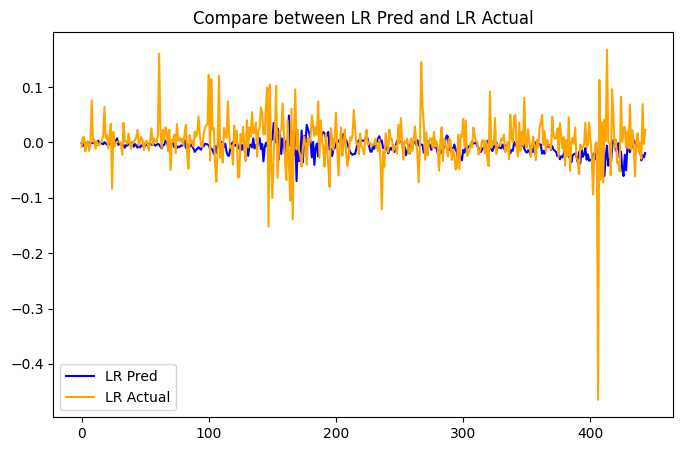

In [139]:
plt.figure(figsize=(8,5))
plt.plot(lr_preds, color = 'blue')
plt.plot(y_val.reset_index(drop=True), color = 'orange')
plt.title("Compare between LR Pred and LR Actual")
plt.legend(['LR Pred', 'LR Actual'])
save_plot_from_title()
plt.show()


In [140]:
joblib.dump(lr, model_dir + 'Linear_Regressor_Model.pkl')


['../models/Linear_Regressor_Model.pkl']

#### Model_3 == RandomForest Regressor

In [141]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_leaf=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train.ravel())
rf_preds_scaled = rf.predict(X_val)
# rf_preds = y_scaler.inverse_transform(rf_preds_scaled.reshape(-1,1)).flatten()


In [142]:
rf_rmse, rf_mae, rf_mape, rf_dir = evaluate_model(y_val.reset_index(drop=True), rf_preds_scaled)
rf_rmse, rf_mae, rf_mape, rf_dir


(0.04219520101521864,
 0.02537600510225271,
 153.14215535344547,
 0.5011286681715575)

Saved plot: ../reports\Compare_between_RF_Pred_and_RF_Actual.png


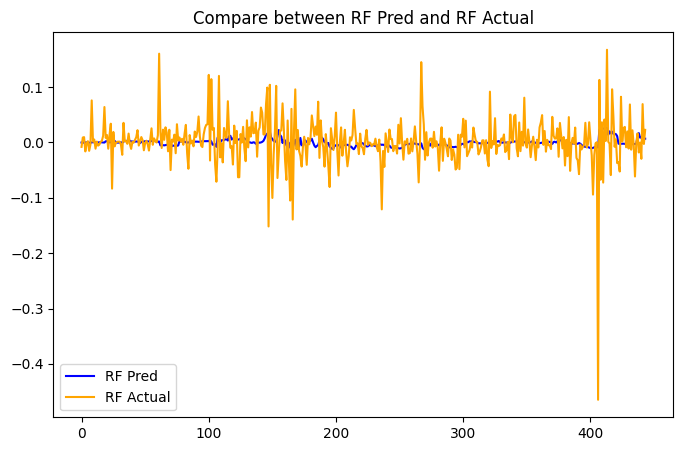

In [143]:
plt.figure(figsize=(8,5))
plt.plot(rf_preds_scaled, color = 'blue')
plt.plot(y_val.reset_index(drop=True), color = 'orange')
plt.title("Compare between RF Pred and RF Actual")
plt.legend(['RF Pred', 'RF Actual'])
save_plot_from_title()
plt.show()


In [144]:
lag_indices = [i for i, col in enumerate(INPUT_FEATURES) if 'Close_lag' in col]


In [145]:
X_last = X_test.values[-1]


In [146]:
forecast_7_rf  = multi_step_forecast_ml(rf, X_last, 7, lag_indices)
forecast_15_rf = multi_step_forecast_ml(rf, X_last, 15, lag_indices)
forecast_30_rf = multi_step_forecast_ml(rf, X_last, 30, lag_indices)
dir_7  = multi_step_directional_accuracy(y_test[-7:], forecast_7_rf)
dir_15 = multi_step_directional_accuracy(y_test[-15:], forecast_15_rf)
dir_30 = multi_step_directional_accuracy(y_test[-30:], forecast_30_rf)
dir_7, dir_15, dir_30    


(0.8333333333333334, 0.5, 0.4482758620689655)

##### 7 days forecasting (RF)

Saved plot: ../reports\7-Day_Forecast__RF__Directional_Accuracy___83_33_.png


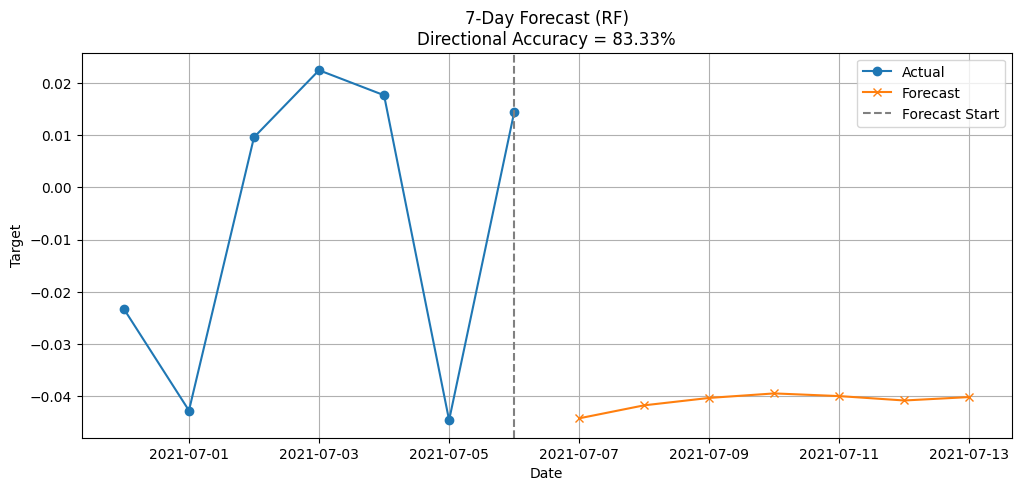

In [147]:
plot_multistep_forecast(y_test, 
                        forecast_7_rf, 
                        steps=7, 
                        dir_acc=dir_7, 
                        title_suffix="(RF)")


##### 15 days forecast (RF)

Saved plot: ../reports\15-Day_Forecast__RF__Directional_Accuracy___50_00_.png


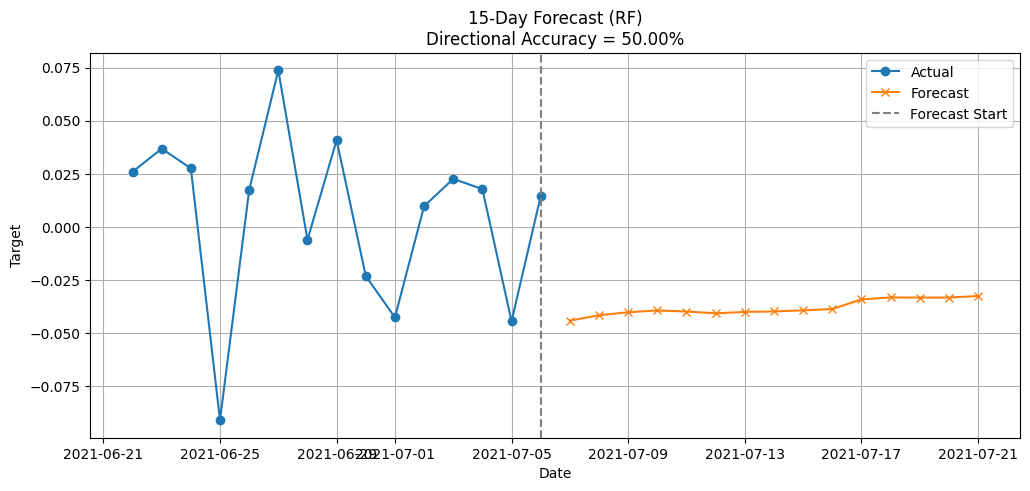

In [148]:

plot_multistep_forecast(y_test, 
                        forecast_15_rf, 
                        steps=15, 
                        dir_acc=dir_15, 
                        title_suffix="(RF)")


##### 30 days forecast (RF)

Saved plot: ../reports\30-Day_Forecast__RF__Directional_Accuracy___44_83_.png


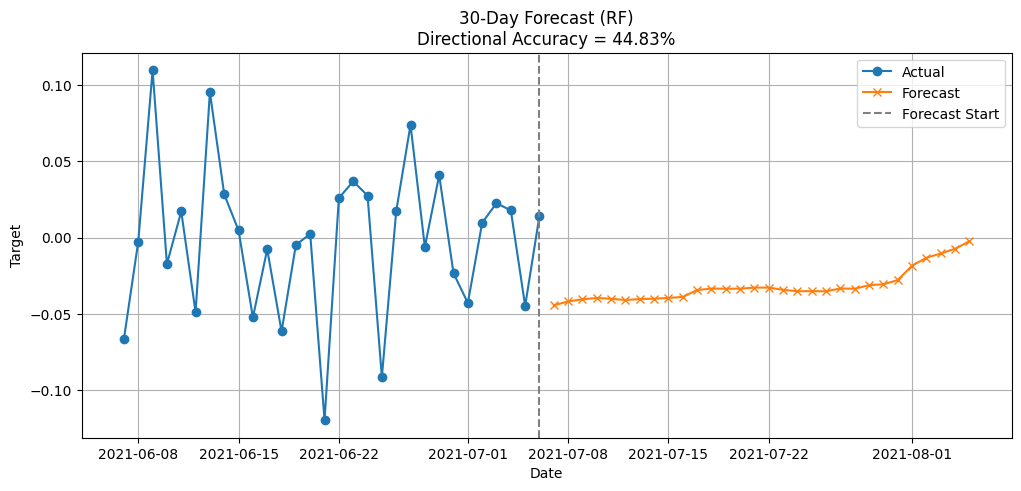

In [149]:
plot_multistep_forecast(y_test, 
                        forecast_30_rf, 
                        steps=30, 
                        dir_acc=dir_30, 
                        title_suffix="(RF)")


In [150]:
joblib.dump(rf, model_dir + 'RandomForest_Regressor_Model.pkl')


['../models/RandomForest_Regressor_Model.pkl']

#### Model_4 == XGBoost

In [151]:
xgb_model = XGBRegressor(n_estimators=500, 
                         max_depth=5, 
                         learning_rate=0.05, 
                         subsample=0.8, 
                         colsample_bytree=0.8,
                         objective='reg:squarederror', 
                         random_state=42, n_jobs=-1)


In [152]:
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [153]:
xgb_preds = xgb_model.predict(X_val)


In [154]:
xgb_rmse, xgb_mae, xgb_mape, xgb_dir = evaluate_model(y_val.reset_index(drop=True), xgb_preds)
xgb_rmse, xgb_mae, xgb_mape, xgb_dir



(0.0453042099148491, 0.02872663007104724, 272.415763260935, 0.5282167042889391)

In [155]:
joblib.dump(xgb_model, model_dir + 'XGBoost_Model.pkl')


['../models/XGBoost_Model.pkl']

In [156]:
model_info = {"model": "XGBoost", "features": INPUT_FEATURES, "target": "next_day_return", "window": 30}


In [157]:
joblib.dump(model_info, model_dir + 'XGB_metadata.pkl')


['../models/XGB_metadata.pkl']

In [158]:
xgb_importance = pd.Series(xgb_model.feature_importances_, index=INPUT_FEATURES).sort_values(ascending=False)


Saved plot: ../reports\XGBoost_Feature_Importance.png


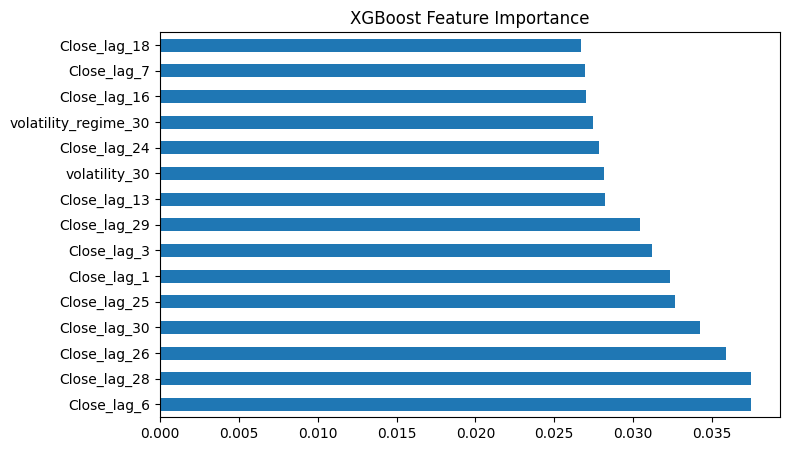

In [159]:
xgb_importance.head(15).plot(kind='barh', figsize=(8,5))
plt.title("XGBoost Feature Importance")
save_plot_from_title()
plt.show()


Saved plot: ../reports\Compare_between_XGB_Pred_and_XGB_Actual.png


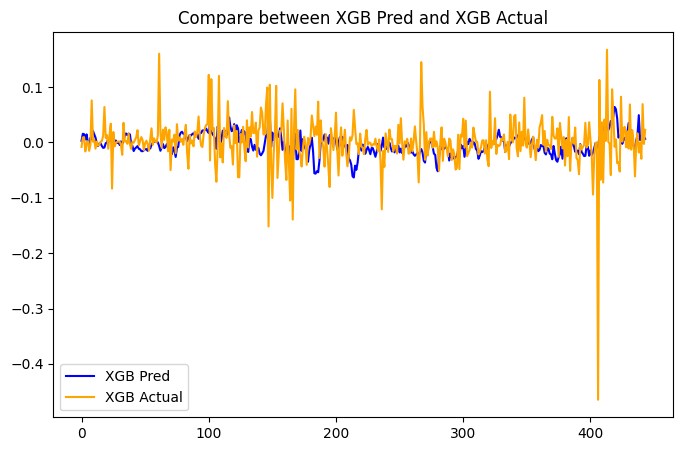

In [160]:
plt.figure(figsize=(8,5))
plt.plot(xgb_preds, color = 'blue')
plt.plot(y_val.reset_index(drop=True), color = 'orange')
plt.title("Compare between XGB Pred and XGB Actual")
plt.legend(['XGB Pred', 'XGB Actual'])
save_plot_from_title()
plt.show()


In [161]:
forecast_7_xgb  = multi_step_forecast_ml(xgb_model, X_last, 7, lag_indices)
forecast_15_xgb = multi_step_forecast_ml(xgb_model, X_last, 15, lag_indices)
forecast_30_xgb = multi_step_forecast_ml(xgb_model, X_last, 30, lag_indices)
xgb_dir_7  = multi_step_directional_accuracy(y_test[-7:], forecast_7_xgb)
xgb_dir_15 = multi_step_directional_accuracy(y_test[-15:], forecast_15_xgb)
xgb_dir_30 = multi_step_directional_accuracy(y_test[-30:], forecast_30_xgb)
xgb_dir_7, xgb_dir_15, xgb_dir_30    


(0.5, 0.5714285714285714, 0.5172413793103449)

##### 7 days forecast (XGBoost)

Saved plot: ../reports\7-Day_Forecast__XGBoost__Directional_Accuracy___50_00_.png


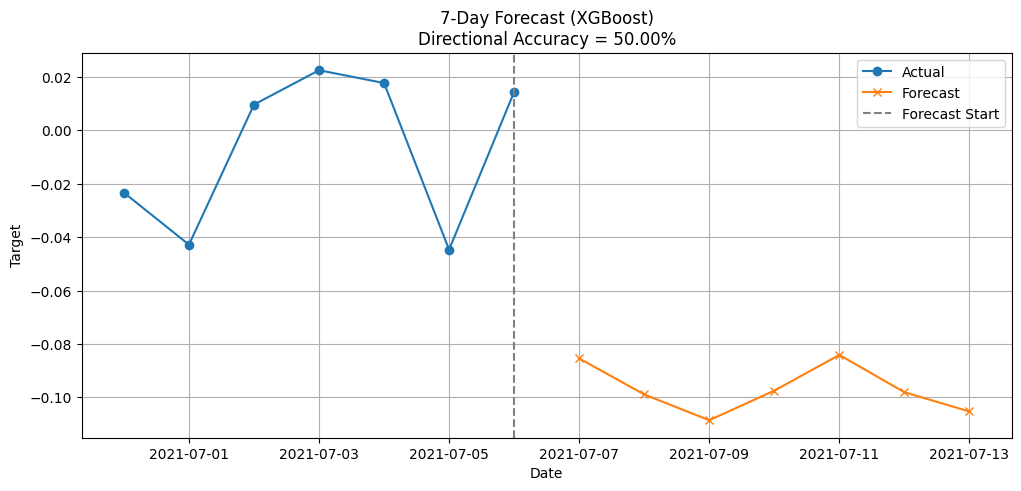

In [162]:
plot_multistep_forecast(y_test, 
                        forecast_7_xgb, 
                        steps=7, 
                        dir_acc=xgb_dir_7, 
                        title_suffix="(XGBoost)")


##### 15 days forecast (XGBoost)

Saved plot: ../reports\15-Day_Forecast__XGBoost__Directional_Accuracy___57_14_.png


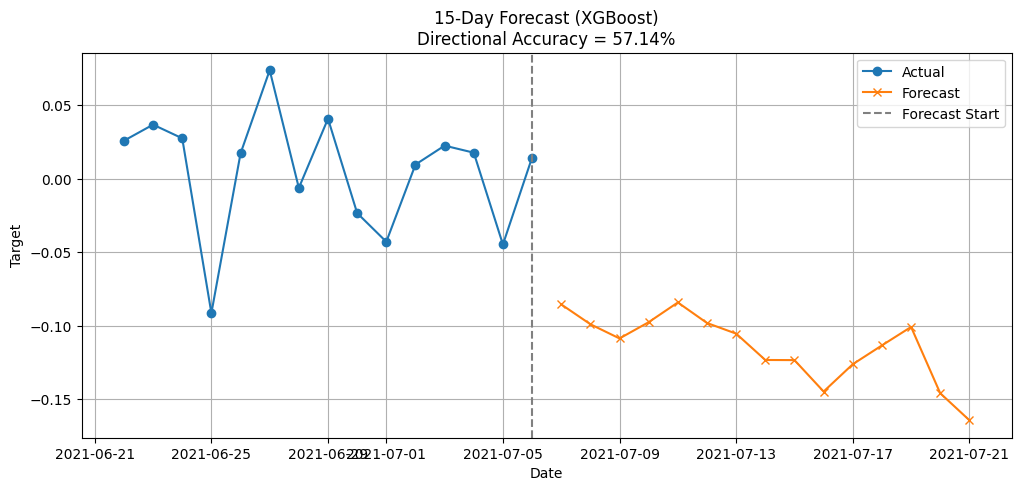

In [163]:
plot_multistep_forecast(y_test, 
                        forecast_15_xgb, 
                        steps=15, 
                        dir_acc=xgb_dir_15, 
                        title_suffix="(XGBoost)")


##### 30 days forecast (XGBoost)

Saved plot: ../reports\30-Day_Forecast__XGBoost__Directional_Accuracy___51_72_.png


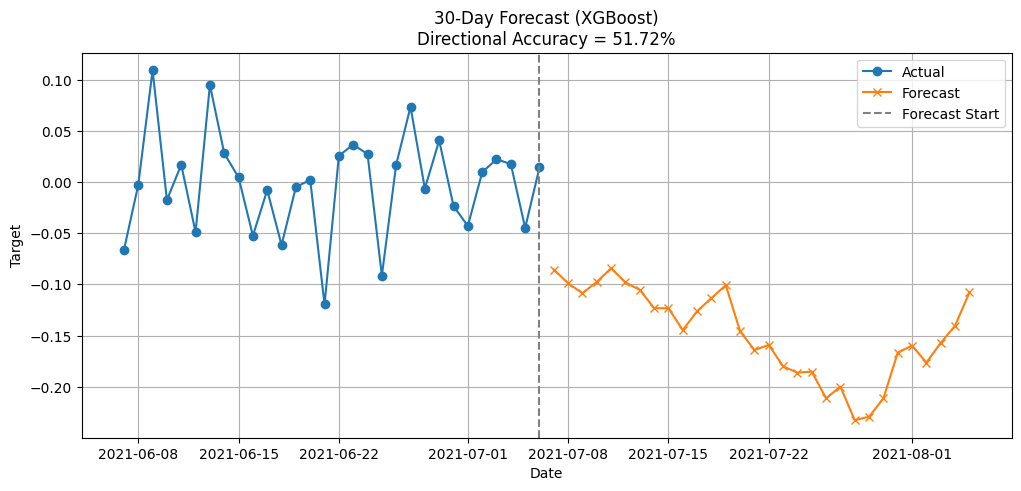

In [164]:
plot_multistep_forecast(y_test, 
                        forecast_30_xgb, 
                        steps=30, 
                        dir_acc=xgb_dir_30, 
                        title_suffix="(XGBoost)")


### Deep learning Models
#### LSTM
##### Sequence Window Creation

In [165]:
lstm_data = encoded_data[['Close', 'Volume', 'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'volatility_7', 'volatility_15', 'volatility_30', 'volatility_regime_30']]
lstm_data['target_price'] = lstm_data['Close'].shift(-1)
lstm_data.head(3)


,Close,Volume,Marketcap,MA_7,MA_15,MA_30,volatility_7,volatility_15,volatility_30,volatility_regime_30,target_price
Date,,,,,,,,,,,
2013-04-29 23:59:59,144.539993,0.0,1.603769e+09,6690.163677,6661.91214,6606.573392,0.034614,0.036281,0.037536,0,139.000000
2013-04-30 23:59:59,139.000000,0.0,1.542813e+09,6690.163677,6661.91214,6606.573392,0.034614,0.036281,0.037536,0,116.989998
2013-05-01 23:59:59,116.989998,0.0,1.298955e+09,6690.163677,6661.91214,6606.573392,0.034614,0.036281,0.037536,0,105.209999


In [166]:
lstm_data.dropna(inplace=True)


In [167]:
LSTM_FEATURES = ['Close', 'Volume', 'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'volatility_7', 'volatility_15', 'volatility_30', 'volatility_regime_30']
LSTM_TARGTE = 'target_price'


In [168]:
n = len(lstm_data)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)


In [169]:
train_df = lstm_data.iloc[:train_end]
val_df   = lstm_data.iloc[train_end:val_end]
test_df  = lstm_data.iloc[val_end:]


In [170]:
DL_X_scaler = MinMaxScaler()
DL_y_scaler = MinMaxScaler()


In [171]:
DL_X_train_scaled = DL_X_scaler.fit_transform(train_df[LSTM_FEATURES])
DL_X_val_scaled   = DL_X_scaler.transform(val_df[LSTM_FEATURES])
DL_X_test_scaled  = DL_X_scaler.transform(test_df[LSTM_FEATURES])
joblib.dump(DL_X_scaler, model_dir + 'DL_X_scaler.pkl')
DL_y_train_scaled = DL_y_scaler.fit_transform(train_df[[LSTM_TARGTE]])
DL_y_val_scaled   = DL_y_scaler.transform(val_df[[LSTM_TARGTE]])
DL_y_test_scaled  = DL_y_scaler.transform(test_df[[LSTM_TARGTE]])
joblib.dump(DL_y_scaler, model_dir + 'DL_y_scaler.pkl')


['../models/DL_y_scaler.pkl']

In [172]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
print(DL_X_train_scaled.shape, DL_y_train_scaled.shape, DL_X_val_scaled.shape, DL_y_val_scaled.shape, DL_X_test_scaled.shape, DL_y_test_scaled.shape)


(2072, 39) (2072,) (444, 39) (444,) (444, 39) (444,)
(2093, 10) (2093, 1) (448, 10) (448, 1) (449, 10) (449, 1)


In [173]:
WINDOW_30 = 30
WINDOW_60 = 60
WINDOW_90 = 90

X_train_seq, y_train_seq = create_sequences(DL_X_train_scaled, DL_y_train_scaled, WINDOW_60)
X_val_seq, y_val_seq     = create_sequences(DL_X_val_scaled, DL_y_val_scaled, WINDOW_60)
X_test_seq, y_test_seq   = create_sequences(DL_X_test_scaled, DL_y_test_scaled, WINDOW_60)


#### LSTM Architecture

In [174]:
lstm_model = Sequential([LSTM(64, return_sequences=True, input_shape=(WINDOW_60, X_train_seq.shape[2])),
                         Dropout(0.2), LSTM(32),
                         Dropout(0.2),
                         Dense(1)])


In [175]:
lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")


In [176]:
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            19200     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________


#### Training with EarlyStopping

In [177]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
early_stop


In [178]:
lstm_model.fit(X_train_seq, y_train_seq, 
               validation_data=(X_val_seq, y_val_seq), 
               epochs=100, 
               batch_size=32, 
               callbacks=[early_stop], 
               verbose=1)



Epoch 1/100
64/64 [==============================] - 8s 70ms/step - loss: 0.0179 - val_loss: 0.0327
Epoch 2/100
64/64 [==============================] - 4s 59ms/step - loss: 0.0050 - val_loss: 0.0241
Epoch 3/100
64/64 [==============================] - 4s 62ms/step - loss: 0.0043 - val_loss: 0.0292
Epoch 4/100
64/64 [==============================] - 4s 59ms/step - loss: 0.0032 - val_loss: 0.0210
Epoch 5/100
64/64 [==============================] - 4s 63ms/step - loss: 0.0031 - val_loss: 0.0222
Epoch 6/100
64/64 [==============================] - 4s 58ms/step - loss: 0.0025 - val_loss: 0.0215
Epoch 7/100
64/64 [==============================] - 4s 60ms/step - loss: 0.0027 - val_loss: 0.0194
Epoch 8/100
64/64 [==============================] - 4s 57ms/step - loss: 0.0025 - val_loss: 0.0166
Epoch 9/100
64/64 [==============================] - 4s 57ms/step - loss: 0.0025 - val_loss: 0.0140
Epoch 10/100
64/64 [==============================] - 4s 58ms/step - loss: 0.0022 - val_loss: 0.0099

In [179]:
lstm_val_preds = lstm_model.predict(X_val_seq, verbose=0)


In [180]:
# Inverse scaling
lstm_pred = y_scaler.inverse_transform(lstm_val_preds.reshape(-1, 1)).flatten()
lstm_true = y_scaler.inverse_transform(y_val_seq.reshape(-1, 1)).flatten()


In [181]:
lstm_val_rmse, lstm_val_mae, lstm_val_mape, lstm_val_dir = evaluate_forecast(lstm_true, lstm_pred)
lstm_val_rmse, lstm_val_mae, lstm_val_mape, lstm_val_dir


(0.026141043093778012,
 0.019089190670267594,
 117.4224329560136,
 0.4935400516795866)

Saved plot: ../reports\Compare_between_LSTM_Val_Pred_and_LSTM_Val_Actual.png


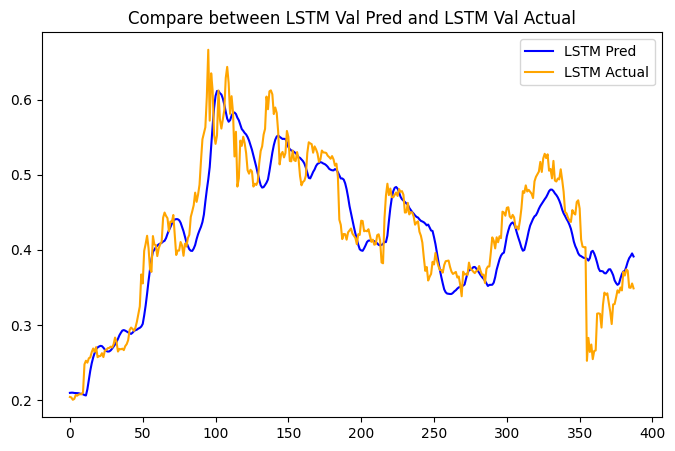

In [182]:
plt.figure(figsize=(8,5))
plt.plot(lstm_val_preds, color = 'blue')
plt.plot(y_val_seq, color = 'orange')
plt.title("Compare between LSTM Val Pred and LSTM Val Actual")
plt.legend(['LSTM Pred', 'LSTM Actual'])
save_plot_from_title()
plt.show()


#### LSTM Evaluation (Next-Day Prediction)

In [183]:
lstm_preds_scaled = lstm_model.predict(X_test_seq, verbose=0)


In [184]:
# Inverse scaling
lstm_pred = y_scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)).flatten()
lstm_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()


In [185]:
lstm_rmse, lstm_mae, lstm_mape, lstm_dir = evaluate_forecast(lstm_true, lstm_pred)
lstm_rmse, lstm_mae, lstm_mape, lstm_dir


(0.3715052079569027, 0.26146303677459093, 39.3733466233269, 0.5077319587628866)

Saved plot: ../reports\Compare_between_LSTM_Test_Pred_and_LSTM_Test_Actual.png


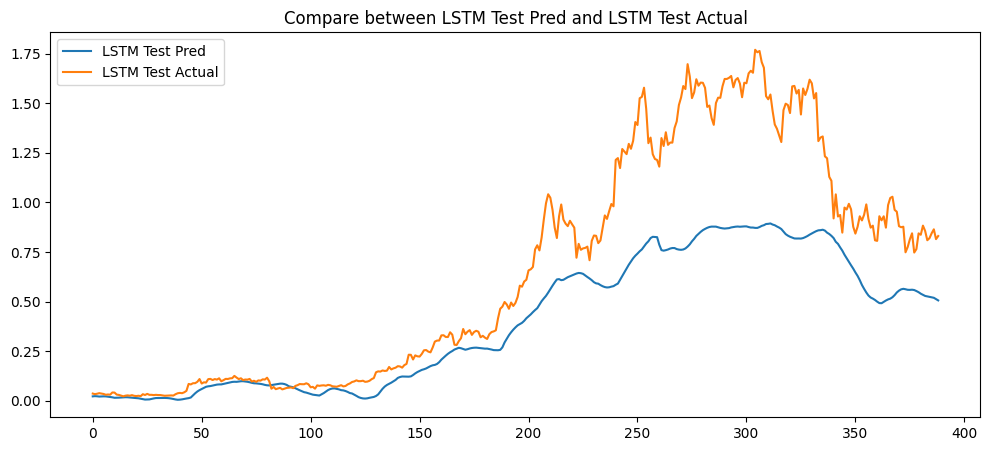

In [186]:
pd.DataFrame({'LSTM_Pred': lstm_pred, 'lstm_test': lstm_true})
plt.figure(figsize=(12,5))
plt.plot(lstm_pred)
plt.plot(lstm_true)
plt.title("Compare between LSTM Test Pred and LSTM Test Actual")
plt.legend(['LSTM Test Pred', 'LSTM Test Actual'])
save_plot_from_title()
plt.show()


In [187]:
lstm_model.save(model_dir+"lstm_model.h5")


#### Multi-Step Forecasting (7 / 15 / 30 Days)

In [188]:
def multi_step_forecast(model, last_sequence, steps):
    preds = []
    seq = last_sequence.copy()
    for _ in range(steps):
        pred = model.predict(seq.reshape(1, *seq.shape), verbose=0)[0,0]
        preds.append(pred)
        seq = np.roll(seq, -1, axis=0)
        seq[-1, 0] = pred
    return y_scaler.inverse_transform(np.array(preds).reshape(-1,1))


In [189]:
last_seq = X_test_seq[-1]


In [190]:


lstm_forecast_7  = multi_step_forecast(lstm_model, last_seq, 7)
lstm_forecast_15 = multi_step_forecast(lstm_model, last_seq, 15)
lstm_forecast_30 = multi_step_forecast(lstm_model, last_seq, 30)


Saved plot: ../reports\_7_15_30_-Day_Price_Forecast__LSTM_.png


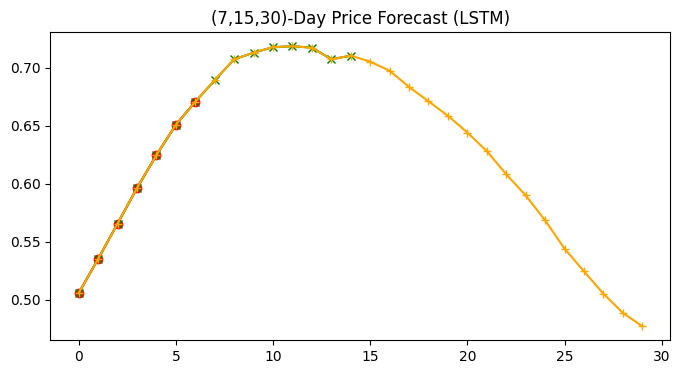

In [191]:
plt.figure(figsize=(8,4))
plt.plot(lstm_forecast_7, marker='o', color = 'red')
plt.plot(lstm_forecast_15, marker='x', color = 'green')
plt.plot(lstm_forecast_30, marker='+', color = 'orange')
plt.title("(7,15,30)-Day Price Forecast (LSTM)")
save_plot_from_title()
plt.show()   


### Build bonus models
like CNN-LSTM

In [192]:
cnn_lstm = Sequential([Conv1D(filters = 64, 
                              kernel_size=3, 
                              activation='relu', 
                              input_shape=(WINDOW_60, X_train_seq.shape[2])),
                       MaxPooling1D(2),
                       LSTM(64),
                       Dropout(0.3),
                       Dense(1)])



In [193]:
cnn_lstm.compile(optimizer=Adam(0.001), loss='mse')


In [194]:
cnn_lstm.summary()  


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 64)            1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 35,073
Trainable params: 35,073
Non-trainable params: 0
__________________________________________________

In [195]:
cnn_lstm.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/100
64/64 [==============================] - 4s 21ms/step - loss: 0.0048 - val_loss: 0.0142
Epoch 2/100
64/64 [==============================] - 1s 14ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 3/100
64/64 [==============================] - 1s 16ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 4/100
64/64 [==============================] - 1s 17ms/step - loss: 0.0013 - val_loss: 0.0133
Epoch 5/100
64/64 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 6/100
64/64 [==============================] - 1s 15ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/100
64/64 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8/100
64/64 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 0.0115
Epoch 9/100
64/64 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 10/100
64/64 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0053

In [196]:
cnn_lstm_preds = cnn_lstm.predict(X_val_seq, verbose=0)
cnn_lstm_preds_flatten = y_scaler.inverse_transform(cnn_lstm_preds).flatten()

cnn_lstm_rmse, cnn_lstm_mae, cnn_lstm_mape, cnn_lstm_dir = evaluate_forecast(y_val_seq, cnn_lstm_preds)
cnn_lstm_rmse, cnn_lstm_mae, cnn_lstm_mape, cnn_lstm_dir


(0.041576287310516845,
 0.02922667743649758,
 7.001140660444364,
 0.5038759689922481)

Saved plot: ../reports\Compare_between_CNN-LSTM_Pred_and_CNN-LSTM_Actual.png


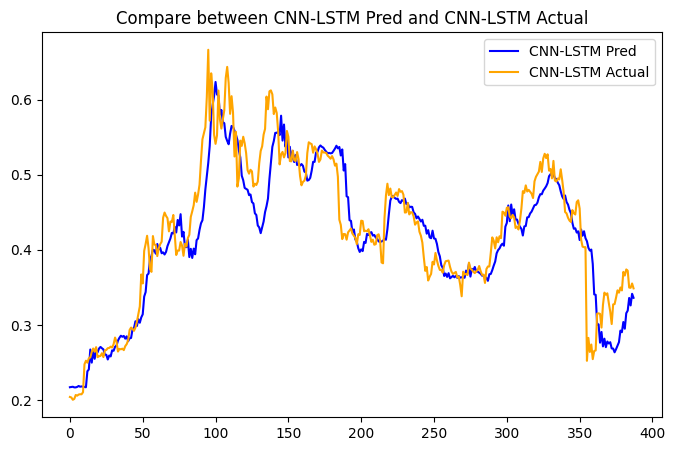

In [197]:
plt.figure(figsize=(8,5))
plt.plot(cnn_lstm_preds, color = 'blue')
plt.plot(y_val_seq, color = 'orange')
plt.title("Compare between CNN-LSTM Pred and CNN-LSTM Actual")
plt.legend(['CNN-LSTM Pred', 'CNN-LSTM Actual'])
save_plot_from_title()
plt.show()


##### Next 7, 15, 30 days forecast CNN-LSTM

Saved plot: ../reports\_7_15_30_-Day_Price_Forecast__CNN-LSTM_.png


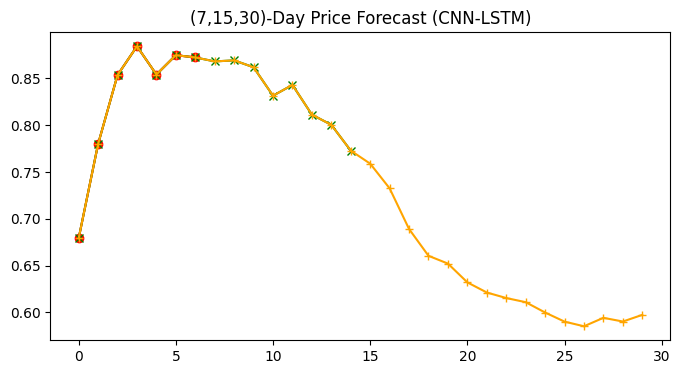

In [198]:
cnn_forecast_7  = multi_step_forecast(cnn_lstm, last_seq, 7)
cnn_forecast_15 = multi_step_forecast(cnn_lstm, last_seq, 15)
cnn_forecast_30 = multi_step_forecast(cnn_lstm, last_seq, 30)

plt.figure(figsize=(8,4))
plt.plot(cnn_forecast_7, marker='o', color = 'red')
plt.plot(cnn_forecast_15, marker='x', color = 'green')
plt.plot(cnn_forecast_30, marker='+', color = 'orange')
plt.title("(7,15,30)-Day Price Forecast (CNN-LSTM)")
save_plot_from_title()
plt.show()


In [199]:
cnn_lstm.save(model_dir + "cnn_lstm_model.h5")


Attention Based Models
- Simple Attention Mechanism

In [200]:
inputs = Input(shape=(WINDOW_60, X_train_seq.shape[2]))
x = LSTM(64, return_sequences=True)(inputs)
attn = Attention()([x, x])
x = GlobalAveragePooling1D()(attn)
outputs = Dense(1)(x)
attn_model = Model(inputs, outputs)


In [201]:
attn_model.compile(optimizer=Adam(0.001), loss='mse')


In [202]:
attn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/100
64/64 [==============================] - 4s 34ms/step - loss: 0.0081 - val_loss: 0.0072
Epoch 2/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0041 - val_loss: 0.0076
Epoch 3/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0036 - val_loss: 0.0379
Epoch 4/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0028 - val_loss: 0.0395
Epoch 5/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0020 - val_loss: 0.0388
Epoch 6/100
64/64 [==============================] - 2s 24ms/step - loss: 0.0017 - val_loss: 0.0693
Epoch 7/100
64/64 [==============================] - 2s 24ms/step - loss: 0.0022 - val_loss: 0.0676
Epoch 8/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - val_loss: 0.0570
Epoch 9/100
64/64 [==============================] - 2s 29ms/step - loss: 0.0015 - val_loss: 0.0667
Epoch 10/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0011 - val_loss: 0.0922

In [203]:
att_preds = attn_model.predict(X_val_seq, verbose=0)
att_preds_flatten = y_scaler.inverse_transform(att_preds).flatten()

att_rmse, att_mae, att_mape, att_dir = evaluate_forecast(y_val_seq, att_preds_flatten)
att_rmse, att_mae, att_mape, att_dir


(0.4339388931723379,
 0.42701571341306377,
 100.29865562334788,
 0.5016191601733336)

Saved plot: ../reports\Compare_between_Attention_Pred_and_Attention_Actual.png


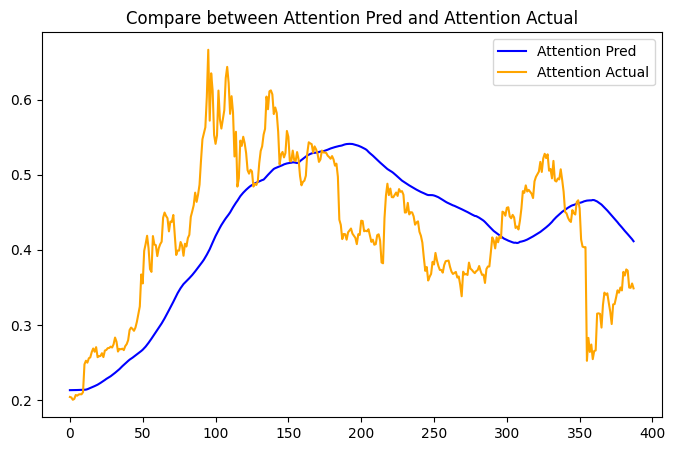

In [204]:
plt.figure(figsize=(8,5))
plt.plot(att_preds, color = 'blue')
plt.plot(y_val_seq, color = 'orange')
plt.title("Compare between Attention Pred and Attention Actual")
plt.legend(['Attention Pred', 'Attention Actual'])
save_plot_from_title()
plt.show()


Saved plot: ../reports\_7_15_30_-Day_Price_Forecast__Attention-based_Model_.png


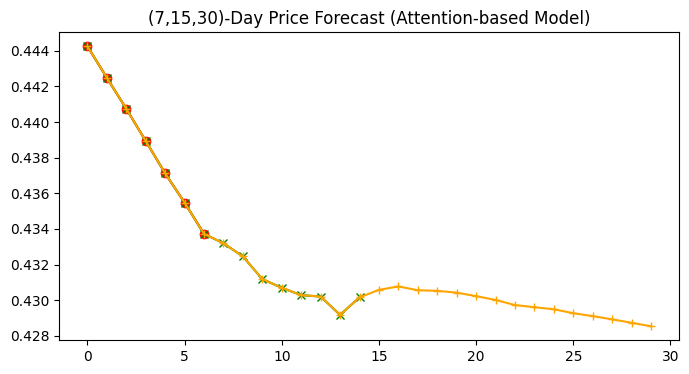

In [205]:
attn_forecast_7  = multi_step_forecast(attn_model, last_seq, 7)
attn_forecast_15 = multi_step_forecast(attn_model, last_seq, 15)
attn_forecast_30 = multi_step_forecast(attn_model, last_seq, 30)
plt.figure(figsize=(8,4))
plt.plot(attn_forecast_7, marker='o', color = 'red')
plt.plot(attn_forecast_15, marker='x', color = 'green')
plt.plot(attn_forecast_30, marker='+', color = 'orange')
plt.title("(7,15,30)-Day Price Forecast (Attention-based Model)")
save_plot_from_title()
plt.show()





In [206]:
attn_model.save(model_dir + "attention_model.h5")


##### Transformer Time-Series Model

In [207]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]


In [208]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),])
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [209]:
embed_dim = X_train_seq.shape[2]
num_heads = 4
ff_dim = 128

inputs = tf.keras.Input(shape=(WINDOW_60, embed_dim))
x = PositionalEncoding(WINDOW_60, embed_dim)(inputs)

x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(1)(x)


In [210]:
transformer_model = tf.keras.Model(inputs, outputs)


In [211]:
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")


In [212]:
transformer_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 10)]          0         
                                                                 
 positional_encoding (Positi  (None, 60, 10)           0         
 onalEncoding)                                                   
                                                                 
 transformer_block (Transfor  (None, 60, 10)           4468      
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, 60, 10)           4468      
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 10)               0         
 (GlobalAveragePooling1D)                                  

In [213]:
transformer_model.fit(X_train_seq, y_train_seq,
                                      validation_data=(X_val_seq, y_val_seq),
                                      epochs=100,
                                      batch_size=32,
                                      callbacks=[early_stop],
                                      verbose=1)


Epoch 1/100
64/64 [==============================] - 6s 37ms/step - loss: 0.0433 - val_loss: 0.1375
Epoch 2/100
64/64 [==============================] - 2s 32ms/step - loss: 0.0078 - val_loss: 0.1097
Epoch 3/100
64/64 [==============================] - 2s 31ms/step - loss: 0.0061 - val_loss: 0.1296
Epoch 4/100
64/64 [==============================] - 2s 32ms/step - loss: 0.0050 - val_loss: 0.1531
Epoch 5/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0044 - val_loss: 0.1604
Epoch 6/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0041 - val_loss: 0.1004
Epoch 7/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0032 - val_loss: 0.1349
Epoch 8/100
64/64 [==============================] - 2s 30ms/step - loss: 0.0029 - val_loss: 0.1473
Epoch 9/100
64/64 [==============================] - 3s 46ms/step - loss: 0.0030 - val_loss: 0.1274
Epoch 10/100
64/64 [==============================] - 2s 39ms/step - loss: 0.0029 - val_loss: 0.1077

In [214]:
trans_preds = transformer_model.predict(X_val_seq, verbose=0)
trans_preds_flatten = y_scaler.inverse_transform(trans_preds).flatten()

trans_rmse, trans_mae, trans_mape, trans_dir = evaluate_forecast(y_val_seq, trans_preds_flatten)
trans_rmse, trans_mae, trans_mape, trans_dir


(0.5723721418478325,
 0.5670306540487929,
 135.29195016143967,
 0.49981638389786937)

Saved plot: ../reports\Compare_between_Transformer_Pred_and_Transformer_Actual.png


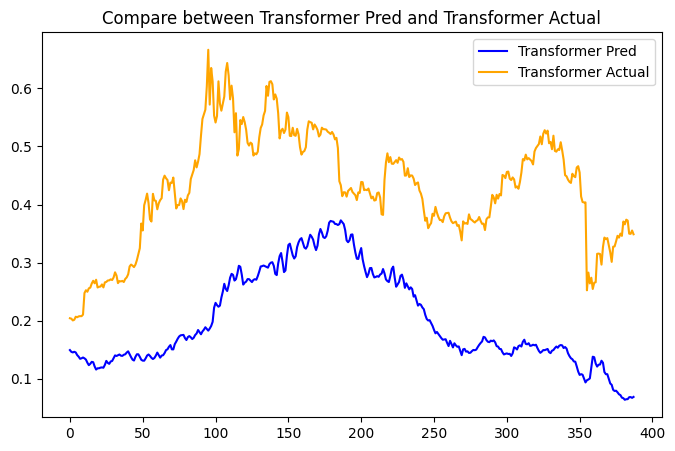

In [215]:
plt.figure(figsize=(8,5))
plt.plot(trans_preds, color = 'blue')
plt.plot(y_val_seq, color = 'orange')
plt.title("Compare between Transformer Pred and Transformer Actual")
plt.legend(['Transformer Pred', 'Transformer Actual'])
save_plot_from_title()
plt.show()


In [216]:
trans_forecast_7  = multi_step_forecast(transformer_model, last_seq, 7)
trans_forecast_15 = multi_step_forecast(transformer_model, last_seq, 15)
trans_forecast_30 = multi_step_forecast(transformer_model, last_seq, 30)


Saved plot: ../reports\_7_15_30_-Day_Price_Forecast__Transformer_.png


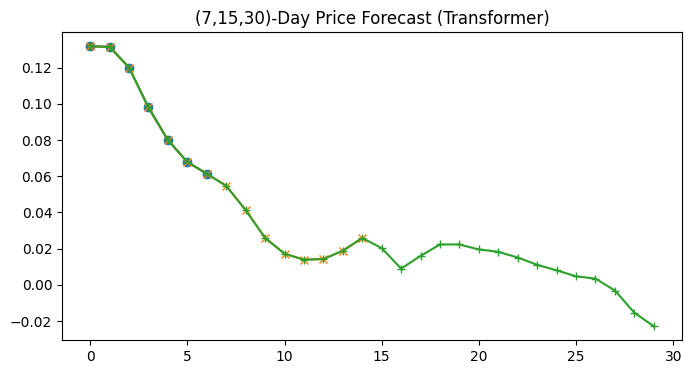

In [217]:
plt.figure(figsize=(8,4))
plt.plot(trans_forecast_7, marker='o')
plt.plot(trans_forecast_15, marker='x')
plt.plot(trans_forecast_30, marker='+')
plt.title("(7,15,30)-Day Price Forecast (Transformer)")
save_plot_from_title()
plt.show()


In [218]:
transformer_model.save(model_dir + "transformer_model.h5")


#### Model Comparision Table

In [219]:
lstm_val_rmse, lstm_val_mae, lstm_val_mape, lstm_val_dir
dl_results = pd.DataFrame({'Model': ['ARIMA', 'Linear Regression', 'Random Forest', 'XGBoost', 'LSTM', 'CNN-LSTM', 'Attention-LSTM', 'Transformer'],
                           'RMSE': [arima_rmse, lr_rmse, rf_rmse, xgb_rmse, lstm_val_rmse, cnn_lstm_rmse, att_rmse, trans_rmse],
                           'MAE': [arima_mae, lr_mae, rf_mae, xgb_mae, lstm_val_mae, cnn_lstm_mae, att_mae, trans_mae],
                           'MAPE (%)': [arima_mape, lr_mape, rf_mape, xgb_mape, lstm_val_mape, cnn_lstm_mape, att_mape, trans_mape],
                           'Directional Accuracy': [arima_dir, lr_dir, rf_dir, xgb_dir, lstm_dir, cnn_lstm_dir, att_dir, trans_dir]})
print(dl_results)


               Model      RMSE       MAE    MAPE (%)  Directional Accuracy
0              ARIMA  0.042584  0.025167         NaN              0.045147
1  Linear Regression  0.045637  0.029228  283.989087              0.512415
2      Random Forest  0.042195  0.025376  153.142155              0.501129
3            XGBoost  0.045304  0.028727  272.415763              0.528217
4               LSTM  0.026141  0.019089  117.422433              0.507732
5           CNN-LSTM  0.041576  0.029227    7.001141              0.503876
6     Attention-LSTM  0.433939  0.427016  100.298656              0.501619
7        Transformer  0.572372  0.567031  135.291950              0.499816


In [220]:
dl_results.to_csv(results_dir + "model_evaluation_results.csv", index=False)


#### Multi step forecasting XGBoost

In [221]:
last_X = X_test.values[-1]
forecast_7  = multi_step_forecast_xgb(xgb_model, last_X, 7)
forecast_15 = multi_step_forecast_xgb(xgb_model, last_X, 15)
forecast_30 = multi_step_forecast_xgb(xgb_model, last_X, 30)



Saved plot: ../reports\Actual_vs_Predicted__30-Day_Forecast_XGBoost_.png


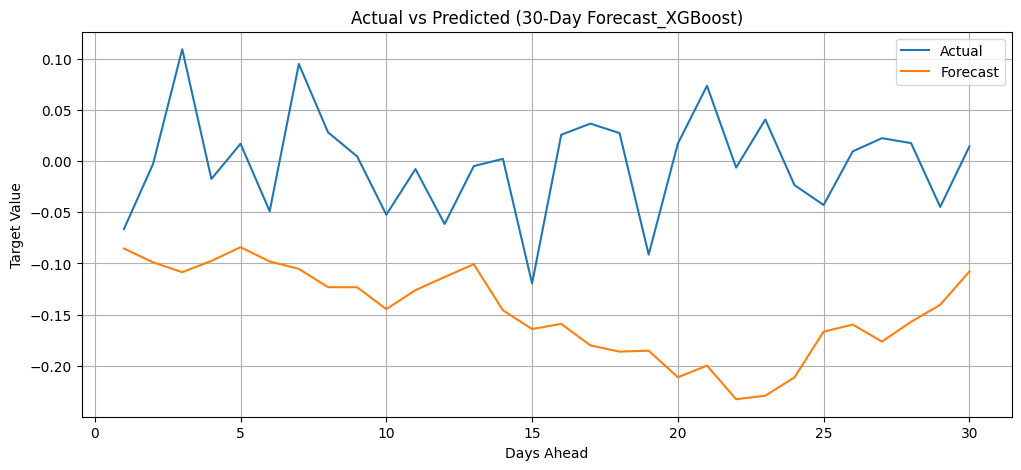

In [222]:
days = np.arange(1, 31)
plt.figure(figsize=(12,5))
plt.plot(days, y_test[-30:], label='Actual')
plt.plot(days, forecast_30_xgb, label='Forecast')
plt.title("Actual vs Predicted (30-Day Forecast_XGBoost)")
plt.xlabel("Days Ahead")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
save_plot_from_title()
plt.show()



In [223]:
errors = y_test[-30:] - forecast_30


Saved plot: ../reports\Forecast_Error_Distribution__30-Day_.png


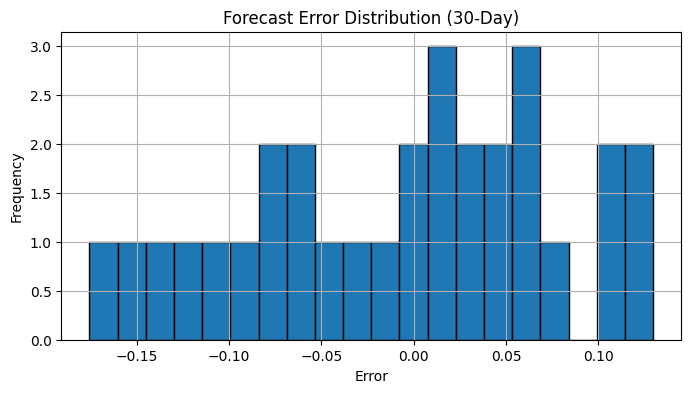

In [224]:
plt.figure(figsize=(8,4))
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Forecast Error Distribution (30-Day)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
save_plot_from_title()
plt.show()


In [225]:
residuals = y_test - xgb_model.predict(X_test)
sigma = np.std(residuals)



In [226]:
upper = forecast_30 + 1.96 * sigma
lower = forecast_30 - 1.96 * sigma


Saved plot: ../reports\30-Day_Forecast_with_Confidence_Interval.png


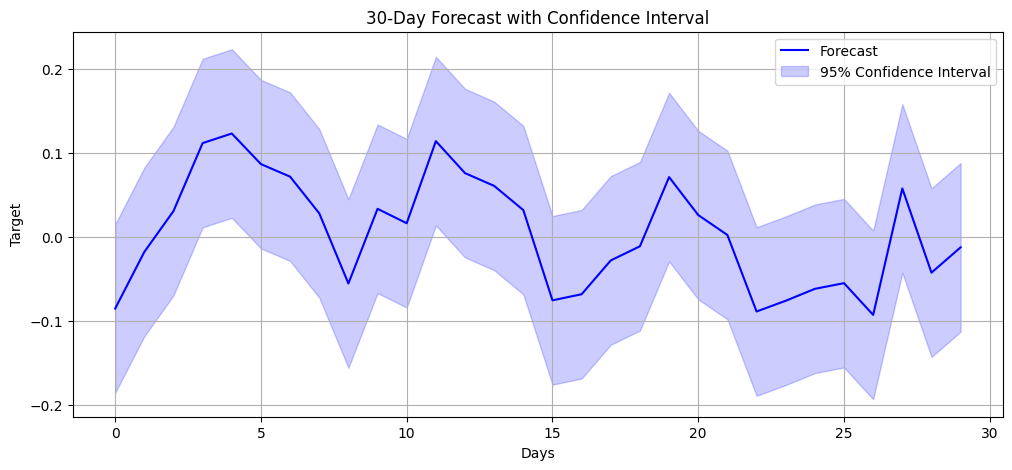

In [227]:
plt.figure(figsize=(12,5))
plt.plot(forecast_30, label='Forecast', color='blue')
plt.fill_between(range(len(forecast_30)), lower, upper, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title("30-Day Forecast with Confidence Interval")
plt.xlabel("Days")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
save_plot_from_title()
plt.show()
